# Absolue Value Deviation Opportunity List

## 2020.01.16

## Innitially we only present 10 opportunities every day.

In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

In [2]:
from pykalman import KalmanFilter

import pandas as pd
import numpy as np
import datetime 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy
import statistics
from scipy import poly1d
from scipy import stats

In [3]:
dt=pd.read_csv('BCCME_20200115.csv',header=None)
metadt=pd.read_csv('BCCME_metadata.csv')
dt.columns=['code','date','open','high','low','close','volume','prev day oi','prev day volume']

In [4]:
#get the tickers of the leading products in Q1 2019
#build up a dictionary for the future manipulation

# can't find KC HRW Wheat product (ticker as 'KC' on CBOT)
agriculture_tickers={'ZC':'Corn Futures','ZS':'Soybean Futures','ZL':'Soybean Oil Futures', 'GF':'Feeder Cattle Futures',
                     'ZM':'Soybean Meal Futures','ZW':'Wheat Futures','LE':'Live Cattle Futures','HE':'Lean Hogs Futures'}

#crude oil brent futures' ticker on NYMEX is 'BZ', but is ''QA' or 'SC' in our dataset, by sum up the volume we find that 
#QA seems to be a reliable one
energy_tickers={'CL':'Crude Oil WTI Futures','NG':'Natural Gas Futures','HO':'ULSD NY Harbor Futures',
                'QA':'Crude Oil Brent (F) Futures','SC':'Crude Oil Brent Futures','RB':'Gasoline RBOB Futures'}

metal_tickers={'GC':'Gold Futures','SI':'Silver Futures','HG':'High Grade Copper Futures',
               'PL':'Platinum Futures','PA':'Palladium Futures'}

#ultra t-bond futures' ticker is 'UB' on CME while 'UD' in the dataset
interest_rate_tickers={'GE':'Eurodollar Futures','ZN':'10-Year T-Note Futures','ZF':'5-Year T-Note Futures',
                       'ZT':'2-Year T-Note Futures','ZB':'T-Bond Futures','ZQ':'30-Day Fed Funds Futures',
                       'UD':'Ultra T-Bond Futures','TN':'Ultra 10-Year T-Note Futures'}

#can't find the e-mini mid cap futures, e-mini russel 2000 futures and other nikkei futures
equity_tickers={'ES':'S&P 500 E-Mini Futures','SP':'S&P 500 Index Futures','NQ':'Nasdaq 100 E-Mini Futures',
                'YM':'Nikkei 225 Futures'}

#canadian dollars futures ticker is '6C' on CME,other futures' tickers should change the order of the number and letter
FX_tickers={'E6':'Euro FX Futures','J6':'Japanese Yen Futures','B6':'British Pound Futures',
            'A6':'Australian Dollar Futures','D6':'Canadian Dollar Futures','M6':'Mexican Peso Futures',
            'S6':'Swiss Franc Futures'}

#write a function to get the contract month ticker dictionary
def get_contract_month(ticker):
    """
    ticker is the tickers of the futures contracts 
    """
    my_list=['F','G','H','J','K','M','N','Q','U','V','X','Z']
    my_dic={}
    for i in range(12):
        my_dic[ticker+my_list[i]]=i+1        
    return my_dic

#write a function to get the key in a dictionary based on the value
def get_key(dictionary,value):
    if value%12==0:return list(dictionary.keys())[-1]
    for k in dictionary.keys():
        if dictionary[k]==value%12:
            return k
        
def get_ticker_dic():
    return {'ZC':'Corn Futures','ZS':'Soybean Futures','ZL':'Soybean Oil Futures','ZM':'Soybean Meal Futures',
            'ZW':'Wheat Futures','LE':'Live Cattle Futures','HE':'Lean Hogs Futures','GF':'Feeder Cattle Futures',
            'CL':'Crude Oil WTI Futures','NG':'Natural Gas Futures','HO':'ULSD NY Harbor Futures',
            'QA':'Crude Oil Brent (F) Futures','SC':'Crude Oil Brent Futures','RB':'Gasoline RBOB Futures',
            'GC':'Gold Futures','SI':'Silver Futures','HG':'High Grade Copper Futures','PL':'Platinum Futures',
            'PA':'Palladium Futures','GE':'Eurodollar Futures','ZN':'10-Year T-Note Futures',
            'ZF':'5-Year T-Note Futures','ZT':'2-Year T-Note Futures','ZB':'T-Bond Futures',
            'ZQ':'30-Day Fed Funds Futures','UD':'Ultra T-Bond Futures','TN':'Ultra 10-Year T-Note Futures',
            'ES':'S&P 500 E-Mini Futures','SP':'S&P 500 Index Futures','NQ':'Nasdaq 100 E-Mini Futures',
            'YM':'Nikkei 225 Futures','E6':'Euro FX Futures','J6':'Japanese Yen Futures','B6':'British Pound Futures',
            'A6':'Australian Dollar Futures','D6':'Canadian Dollar Futures','M6':'Mexican Peso Futures',
            'S6':'Swiss Franc Futures'}

def get_ticker_size_dic():
    return {'ZC':[0.25,12.5],'ZS':[0.25,12.5],'ZL':[0.01,6],'ZM':[0.1,10],'ZW':[0.25,12.5],'LE':[0.025,10],'GF':[0.025,12.5],
            'HE':[0.025,10],'CL':[0.01,10],'NG':[0.001,10],'HO': [0.0001,4.2],'QA':[0.01,10],
            'SC':[0.01,10],'RB':[0.0001,4.2],'GC':[0.1,10],'SI':[0.001,5],'HG':[0.0005,12.5],'PL':[0.1,5],
            'PA':[0.1,10],'GE':[0.005,12.5],'ZN':[0.0078125,7.8125],'ZF':[0.0078125,7.8125],
            'ZT':[0.00390625,7.8125],'ZB':[0.0078125,7.8125],'ZQ':[0.0025,10.4175],'UD':[0.0078125,7.8125],
            'TN':[0.0078125,7.8125],'ES':[0.05,2.5],'SP':[0.05,12.5],'NQ':[0.25,5],'YM':[1,5],'E6':[0.00005,6.25],
            'J6':[0.00005,6.25],'B6':[0.00005,3.125],'A6':[0.00005,5],'D6':[0.00005,5],'M6':[0.00001,1],'S6':[0.00005,6.25]}

#write a function to get the relevant files we need
def get_futures_file(dic,ticker):
    """
    this function is used to generate the whole time series dataframe for a typical futures
    
    ticker is the name of the futures product on quandl
    
    note that the ticker of the futures product could be slightly different from what we can see on CME
    """
    #get the file meets the codes of the contract 
    my_cols = [col for col in metadt.name if dic[ticker] in col]
    my_code=metadt[metadt.name.isin(my_cols)]
    my_cols = [col for col in my_code.code if ticker in col]
    my_code=my_code[my_code.code.isin(my_cols)]
    my_file=dt[dt.code.isin(my_code.code)]

    my_file['date'] =pd.to_datetime(my_file.date)
    my_file=my_file.sort_values(by=['date'])
    my_file=my_file.set_index('date')

    contract_month=get_contract_month(ticker)
    Contract_month=[]
    for c in my_file.code:
        Contract_month.append(datetime.date(year=int(c[len(ticker)+1:]),month=contract_month[c[:len(ticker)+1]],day=15))
    my_file['Contract_month']=Contract_month 
    
    my_file.to_csv(dic[ticker]+'.csv')
    
def get_range_list(name):
    """
    this function is used to generate the range list based on the spread name
    """
    
    My_dic=get_contract_month(name[1:3])
    value=My_dic[name[1:4]]
    
    if 'butterfly' in name:
        value1=My_dic[name[11:14]]+12*(int(name[14:18])-int(name[4:8]))-value
        value2=My_dic[name[19:22]]+12*(int(name[22:26])-int(name[4:8]))-value
        range_list=[value1,value2-value1]
        
    elif 'doubleflies' in name:
        value1=My_dic[name[11:14]]+12*(int(name[14:18])-int(name[4:8]))-value
        value2=My_dic[name[21:24]]+12*(int(name[24:28])-int(name[4:8]))-value
        value3=My_dic[name[29:32]]+12*(int(name[32:36])-int(name[4:8]))-value
        range_list=[value1,value2-value1,value3-value2]
        
    else:
        value1=My_dic[name[9:12]]+12*(int(name[12:16])-int(name[4:8]))-value
        value2=My_dic[name[17:20]]+12*(int(name[20:24])-int(name[4:8]))-value
        value3=My_dic[name[25:28]]+12*(int(name[28:32])-int(name[4:8]))-value
        range_list=[value1,value2-value1,value3-value2]
        
    return range_list

#write a function to get a spread's easy name
def get_easy_name(spread_name):
    name_dic=get_ticker_dic()
    ticker=spread_name[1:3]
    part1=name_dic[ticker][:-7]
    if 'ULSD' in part1:
        part1 = 'Heating Oil '
    if 'butterfly' in spread_name:
        part2=spread_name[3]+'/'+spread_name[13]+'/'+spread_name[21]+spread_name[24:26]+' SGL Fly'
    elif 'condor' in spread_name:
        part2=spread_name[3]+'/'+spread_name[11]+'/'+spread_name[19]+'/'+spread_name[27]+spread_name[30:32]+' Condor'
    elif 'doubleflies' in spread_name:
        part2=spread_name[3]+'/'+spread_name[13]+'/'+spread_name[23]+'/'+spread_name[31]+spread_name[34:36]+' DBL Flys'
    return part1+part2
    
def butterfly_spread_df(near_contract,range_list,tradable=True):

    """
    this function is used to construct a dataframe of butterfly spread
    
    dic is the dictionary where the ticker is in
    
    near_contract is the contract ticker of the near leg
    
    range_list is a list of the width of the wing (in months)
    
    tradable is the bool value indicating if we should exclude the date before the first date the lowest contract's volume is 
    
    non-zero, default as False
    
    return a list including dataframe with 5 columns: 1) close price spread in terms of ticks 2)sum of volume 
    
    3)the highest volume within 3 legs 4)the lowest volume within 3 legs 
    
    contract-structure name
    """

    tikers_dic=get_ticker_dic()
    
    tick_size_dic=get_ticker_size_dic()
    
    ticker=near_contract[:len(near_contract)-5]
    file_name=tikers_dic[ticker]+'.csv'
    my_file=pd.read_csv(file_name)
    my_file['date'] =pd.to_datetime(my_file.date)
    my_file=my_file.set_index('date')
    
    #get the tick size
    tick_size=tick_size_dic[ticker][0]

    #get the contract month dictionary; key is the ticker and value is the month number
    contract_month=get_contract_month(ticker=ticker)
    contract_ticker=my_file.code.unique()

    #firstly, find the mid-term contract and the furthur-term contract
    value1=contract_month[near_contract[:len(near_contract)-4]]+range_list[0];value2=value1+range_list[1]
    if value1<=12:
        mid_contract=get_key(contract_month,value1)+near_contract[len(near_contract)-4:]
    elif value1%12==0:
        mid_contract=get_key(contract_month,value1)+str(int(near_contract[len(near_contract)-4:])+value1//12-1)
    else:
        mid_contract=get_key(contract_month,value1)+str(int(near_contract[len(near_contract)-4:])+value1//12)
        
    if value2<=12:
        furthur_contract=get_key(contract_month,value2)+near_contract[len(near_contract)-4:]
    elif value2%12==0:
        furthur_contract=get_key(contract_month,value2)+str(int(near_contract[len(near_contract)-4:])+value2//12-1)
    else:
        furthur_contract=get_key(contract_month,value2)+str(int(near_contract[len(near_contract)-4:])+value2//12)
    
    contract_list=[near_contract,mid_contract,furthur_contract]

    #warning if the contract is not in the list
    if near_contract not in contract_ticker:
#         print ('near term contract dose not exist!')
        return
    
    if mid_contract not in contract_ticker:
#         print ('mid term contract dose not exist!')
        return
    
    if furthur_contract not in contract_ticker:
#         print ('furthur term contract dose not exist!')
        return

    #get the first trade date and the last trade date data
    first_trade_date=[];last_trade_date=[]
    for c in contract_list:
        first_trade_date.append(my_file[my_file.code==c].index[0])
        last_trade_date.append(my_file[my_file.code==c].index[-1])
    last_date=min(last_trade_date)
    first_date=max(first_trade_date)
    
    #warning if buttfly does not exist
    if first_date>=last_date:
#         print ('Butterfly Spread does not exist')
        return
    
    #get the data within trading days
    mask = (my_file.index>=first_date) & (my_file.index<=last_date)
    newdf=my_file.loc[mask]
    newdf=newdf[newdf.code.isin(contract_list)]

    #thirdly,calculate the butterfly spread and construct a dateframe
    close_spread=[];sum_volume=[];highest_volume=[];lowest_volume=[]
    for i in range(len(newdf.index.unique())):    
        date=newdf.index.unique()[i]
        #The trading date which can not construct a spread gives us invalid value
        if len(newdf[newdf.index==date])<3:
            close_spread.append(None)    
        else:        
            close_price=newdf[newdf.index==date].sort_values(by='Contract_month').close
            close_spread.append(round((close_price[0]+close_price[2]-2*close_price[1])/tick_size)) 
#             close_spread.append(close_price[0]+close_price[2]-2*close_price[1])

    for i in range(len(newdf.index.unique())-1):    
        shift_date=newdf.index.unique()[i+1]
        sum_volume.append(sum(newdf[newdf.index==shift_date]['prev day volume']))
        highest_volume.append(max(newdf[newdf.index==shift_date]['prev day volume']))
        lowest_volume.append(min(newdf[newdf.index==shift_date]['prev day volume']))
    
    sum_volume.append(None)
    highest_volume.append(None)
    lowest_volume.append(None)

    output_df={'date':newdf.index.unique(),'close_spread':close_spread,'sum_volume':sum_volume,
               'highest_volume':highest_volume,'lowest_volume':lowest_volume}

    #output the data and we don't interpolate the nan values
    output_df=pd.DataFrame(output_df)
    #consider the tradability in terms of lowest contract's volume
    if tradable==True:
        output_df=output_df.iloc[list(np.nonzero(np.array(output_df.lowest_volume))[0])].set_index('date')
    else:
        output_df=output_df.set_index('date')

    return [output_df,'+'+near_contract+'-2*'+mid_contract+'+'+furthur_contract+' butterfly spread']

def condor_spread_df(near_contract,range_list,tradable=True,doubleflies=False):

    """
    this function is used to construct a dataframe of condor spread
    
    near_contract is the contract ticker of the near leg
    
    range_list is a list of the widths (in months) in between the near two legs, should have 3 numbers 
    
    tradable is the bool value indicating if we should exclude the date before the first date the lowest contract's volume is 
    
    non-zero, default as True
    
    doubleflies is the bool value indicating if we are computing the price of doubleflies, default as False
    
    return a list including A: dataframe with 4 columns: 1) close price spread in terms of ticks 2)sum of volume  
    
    3)the highest volume within 4 legs 9)the lowest volume among 4 legs 
    
    B: contract-structure name
    """

    tikers_dic=get_ticker_dic()
    
    tick_size_dic=get_ticker_size_dic()

    ticker=near_contract[:len(near_contract)-5]
    file_name=tikers_dic[ticker]+'.csv'
    my_file=pd.read_csv(file_name)
    my_file['date'] =pd.to_datetime(my_file.date)
    my_file=my_file.set_index('date')
    
    #get the tick size
    tick_size=tick_size_dic[ticker][0]

    #get the contract month dictionary; key is the ticker and value is the month number
    contract_month=get_contract_month(ticker=ticker)
    contract_ticker=my_file.code.unique()

    #firstly, find the mid-term contract and the furthur-term contract
    value1=contract_month[near_contract[:len(near_contract)-4]]+range_list[0];
    value2=value1+range_list[1]
    value3=value2+range_list[2]
    
    if value1<=12:
        mid_contract=get_key(contract_month,value1)+near_contract[len(near_contract)-4:]
    elif value1%12==0:
        mid_contract=get_key(contract_month,value1)+str(int(near_contract[len(near_contract)-4:])+value1//12-1)
    else:
        mid_contract=get_key(contract_month,value1)+str(int(near_contract[len(near_contract)-4:])+value1//12)
        
    if value2<=12:
        furthur_contract=get_key(contract_month,value2)+near_contract[len(near_contract)-4:]
    elif value2%12==0:
        furthur_contract=get_key(contract_month,value2)+str(int(near_contract[len(near_contract)-4:])+value2//12-1)
    else:
        furthur_contract=get_key(contract_month,value2)+str(int(near_contract[len(near_contract)-4:])+value2//12)
        
    if value3<=12:
        far_furthur_contract=get_key(contract_month,value3)+near_contract[len(near_contract)-4:]
    elif value3%12==0:
        far_furthur_contract=get_key(contract_month,value3)+str(int(near_contract[len(near_contract)-4:])+value3//12-1)
    else:
        far_furthur_contract=get_key(contract_month,value3)+str(int(near_contract[len(near_contract)-4:])+value3//12)
    contract_list=[near_contract,mid_contract,furthur_contract,far_furthur_contract]

    #warning if the contract is not in the list
    if near_contract not in contract_ticker:
#         print ('near term contract dose not exist!')
        return
    
    if mid_contract not in contract_ticker:
#         print ('mid term contract dose not exist!')
        return
    
    if furthur_contract not in contract_ticker:
#         print ('furthur term contract dose not exist!')
        return
    
    if far_furthur_contract not in contract_ticker:
#         print ('far furthur term contract dose not exist!')
        return

    #get the first trade date and the last trade date data
    first_trade_date=[];last_trade_date=[]
    for c in contract_list:
        first_trade_date.append(my_file[my_file.code==c].index[0])
        last_trade_date.append(my_file[my_file.code==c].index[-1])
    last_date=min(last_trade_date)
    first_date=max(first_trade_date)
    
    #warning if buttfly does not exist
    if first_date>=last_date:
#         print ('Condor Spread does not exist')
        return
    
    #get the data within trading days
    mask = (my_file.index>=first_date) & (my_file.index<=last_date)
    newdf=my_file.loc[mask]
    newdf=newdf[newdf.code.isin(contract_list)]

    #thirdly,calculate the butterfly spread and construct a dateframe
    close_spread=[];sum_volume=[];highest_volume=[];lowest_volume=[]

    for i in range(len(newdf.index.unique())):    
        date=newdf.index.unique()[i]
        #The trading date which can not construct a spread gives us invalid value
        if len(newdf[newdf.index==date])<4:
            close_spread.append(None)    

        else:        
            close_price=newdf[newdf.index==date].sort_values(by='Contract_month').close
#             close_spread.append(round((close_price[0]+close_price[3]-close_price[1]-close_price[2])/tick_size))
            if doubleflies==False:
                close_spread.append(round((close_price[0]+close_price[3]-close_price[1]-close_price[2])/tick_size))
            else:
                close_spread.append(round((close_price[0]-close_price[3]-3*close_price[1]+3*close_price[2])/tick_size))
            
    for i in range(len(newdf.index.unique())-1):    
        shift_date=newdf.index.unique()[i+1]
        sum_volume.append(sum(newdf[newdf.index==shift_date]['prev day volume']))
        highest_volume.append(max(newdf[newdf.index==shift_date]['prev day volume']))
        lowest_volume.append(min(newdf[newdf.index==shift_date]['prev day volume']))
       
    sum_volume.append(None)
    highest_volume.append(None)
    lowest_volume.append(None)

    output_df={'date':newdf.index.unique(),'close_spread':close_spread,'sum_volume':sum_volume,
               'highest_volume':highest_volume,'lowest_volume':lowest_volume}

    #output the data and we don't interpolate the nan values
    output_df=pd.DataFrame(output_df)
    #consider the tradability in terms of lowest contract's volume
    if tradable==True:
        output_df=output_df.iloc[list(np.nonzero(np.array(output_df.lowest_volume))[0])].set_index('date')
    else:
        output_df=output_df.set_index('date')
        
    if doubleflies==False:
        return [output_df, '+'+near_contract+'-'+mid_contract+'-'+furthur_contract+'+'+far_furthur_contract+' condor spread']
    else:
        return [output_df, '+'+near_contract+'-3*'+mid_contract+'+3*'+furthur_contract+'-'+far_furthur_contract+' doubleflies spread']
    
def compressed_df(spread_name,range_list,first_year=0,average=1):
    
    """
    this function is used to generate the dataframe of all the year's data on a same scale
    
    spread_name is the current spread we are interested in 
    
    range_list is the span between every two near legs in the spread
    
    first_year is the first year we want to look at, default as 0 and will return all values
    
    average: the N-year period we are looking at plus, default as 1 if we don't want to know any overlapping behaviour
    
    return a data frame
    
    """
    
    tikers_dic=get_ticker_dic()
    
    ticker=spread_name[1:3]

    name_col=['2018']

    #find the first year that the near contract can be traded
    file_name=tikers_dic[ticker]+'.csv'
    my_file=pd.read_csv(file_name)

    contract_ticker=my_file.code.unique()

    if first_year==0:
        first_year=int([t for t in my_file.code.unique() if spread_name[1:4] in t][0][-4:])
    
    else:
        if first_year<int([t for t in my_file.code.unique() if spread_name[1:4] in t][0][-4:]):
            print('No data in your first year!')
            return 

    last_year=int(spread_name[4:8])+1

    if len(range_list)==2:
        dfs=[butterfly_spread_df(spread_name[1:4]+str(2018),range_list,tradable=True)[0].close_spread]
    
        dfs[0].index=dfs[0].index+pd.DateOffset(years=int(spread_name[4:8])-2018)
        
        dfs[0]=dfs[0].groupby('date').mean()
        
        year_list=list(range(first_year,last_year))

        for year in year_list:    
            #find the spread_df in the previous N periods
            name_col.append(str(year))
            same_term_contract=spread_name[1:4]+str(year)
        
            same_term_df=butterfly_spread_df(same_term_contract,range_list,tradable=True)[0].close_spread

            # shift the time and avoid the effect of leap year 
            same_term_df.index=same_term_df.index+pd.DateOffset(years=last_year-year-1)
            # calculate the mean of dataframe group by date to deal with the duplicate date caused by leap year effect
            dfs.append(same_term_df.groupby('date').mean())

        new_df = pd.concat(dfs,axis=1,ignore_index=True)
        #fill in NaN with linear relationship to the closest valid points
        new_df=new_df.interpolate(limit_area='inside')
    
        new_df.columns=name_col
    
    else:
        if 'condor' in spread_name:
            dfs=[condor_spread_df(spread_name[1:4]+str(2018),range_list,tradable=True)[0].close_spread]
        else:
            dfs=[condor_spread_df(spread_name[1:4]+str(2018),range_list,tradable=True,doubleflies=True)[0].close_spread]
    
        dfs[0].index=dfs[0].index+pd.DateOffset(years=int(spread_name[4:8])-2018)
        
        dfs[0]=dfs[0].groupby('date').mean()
        
        year_list=list(range(first_year,last_year))

        for year in year_list:    
            #find the spread_df in the previous N periods
            name_col.append(str(year))
            same_term_contract=spread_name[1:4]+str(year)
            
            if 'condor' in spread_name:
                same_term_df=condor_spread_df(same_term_contract,range_list,tradable=True)[0].close_spread
            else:
                same_term_df=condor_spread_df(same_term_contract,range_list,tradable=True,doubleflies=True)[0].close_spread

            # shift the time and avoid the effect of leap year 
            same_term_df.index=same_term_df.index+pd.DateOffset(years=last_year-year-1)
            # calculate the mean of dataframe group by date to deal with the duplicate date caused by leap year effect
            dfs.append(same_term_df.groupby('date').mean())

        new_df = pd.concat(dfs,axis=1,ignore_index=True)
        #fill in NaN with linear relationship to the closest valid points
        new_df=new_df.interpolate(limit_area='inside')
    
        new_df.columns=name_col
        
    if average>1:
        for i in range((len(name_col)-1)//average-1):
            name_list=[]
            for j in range(i*average,(i+1)*average):                
                name_list.append(name_col[::-1][1:][j])
            new_df[name_list[-1]+'-'+name_list[0]]=new_df[name_list].mean(axis=1)
        
    return new_df.iloc[:,1:]

def Ewa(series,span):
    sma = series.rolling(window=span, min_periods=span).mean()[:span]
    rest =series[span:]
    return pd.concat([sma, rest]).ewm(span=span, adjust=False).mean()

def find_historical_difference(near_contract,range_list,first_day,last_day,data_type,years=10,
                               reference_value='median',doubleflies=False):

    """
    This function is used to compute the historical price referenced values, which are used in the absolute value deviation funciton
    
    first_day is the first we start looking at to pick up the referenced values, last_day is the last day
    
    years is the number of years we want to gather the values,default as 10
    
    reference_value is a string that tells us how we compute the fair value in 'DHP' data type.
        
    """    
    
    #write a function to find the historical price in the past years
    def find_historical_price(near_contract,range_list,first_day,last_day,years,doubleflies=doubleflies):
    
        contract_month=near_contract[:3]
        last_year=int(near_contract[3:])
        data=[]

        for year in range(last_year-years,last_year):
            if len(range_list)==2:
                data+=list(butterfly_spread_df(contract_month+str(year),range_list)[0].close_spread[-first_day:-last_day])
            else:
                data+=list(condor_spread_df(contract_month+str(year),range_list,doubleflies=doubleflies)[0].close_spread[-first_day:-last_day])
            
        return list(pd.Series(data).dropna())
    
    contract_month=near_contract[:3]
    last_year=int(near_contract[3:])
    data=[]
    
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],observation_matrices = [1],initial_state_mean = 0,
                      initial_state_covariance = 1,observation_covariance=1,transition_covariance=.01)
    
    if data_type=='HP':
        return find_historical_price(near_contract,range_list,first_day,last_day,years,doubleflies=doubleflies)
        
    else:
        for year in range(last_year-years,last_year):
############
            if len(range_list)==2:
                #find the differences between the prices and the median (mean) of the past years
                if data_type=='DHP':
                    
                    #find the reference value in the past year
                    historical_price=find_historical_price(contract_month+str(year),range_list,first_day,last_day,years,doubleflies=doubleflies)
                    
                    if reference_value=='median':
                        fair_value=np.median(historical_price)
                    if reference_value=='mean':
                        fair_value=np.mean(historical_price)
                    #calculate the price differences between the prices and the fair value
                    x=butterfly_spread_df(near_contract,range_list)[0].close_spread[-first_day:-last_day]
                    for num in x:
                        data.append(num-fair_value)
                    
                #find the differences between the prices and MA in the past years
                elif data_type=='MA':
                    #find the price
                    x=butterfly_spread_df(contract_month+str(year),range_list)[0].close_spread[-first_day:-last_day]
                    #find the moving average (30)
                    mean30=x.rolling(window = 30).mean()
                    
                    #append the difference to the data list
                    for i in range(len(x)):
                        data.append(x[i]-mean30[i])                    
                    
                #find the k multiple in the past years
                elif data_type=='K':
                    #find the price
                    x=butterfly_spread_df(contract_month+str(year),range_list)[0].close_spread[-first_day:-last_day]
                    #find the moving average (30)
                    mean30=x.rolling(window = 30).mean()
                    #find the BB std
                    std30=x.rolling(window = 30).std()
                    
                    #append the k multiple to the data list
                    for i in range(len(x)):
                        data.append((x[i]-mean30[i])/std30[i])        
            
                #find the differences between the prices and EWA in the past years
                elif data_type=='EWA':
                    #find the price
                    x=butterfly_spread_df(contract_month+str(year),range_list)[0].close_spread[-first_day:-last_day]
                    #find the exponential moving average (30)
                    ewa30 = Ewa(x,30)
                    
                    #append the difference to the data list
                    for i in range(len(x)):
                        data.append(x[i]-ewa30[i])  
                
                #find the differences between the prices and Kalman Estimate in the past years                
                else:
                    x=butterfly_spread_df(contract_month+str(year),range_list)[0].close_spread[-first_day:-last_day]
                    # get the Kalman estimate
                    state_means, _ = kf.filter(x.values)
                    state_means = pd.Series(state_means.flatten(), index=x.index)
                    
                    #append the difference to the data list
                    for i in range(len(x)):
                        data.append(x[i]-state_means[i])  
############                    
            else:
                #find the differences between the prices and the median (mean) of the past years
                if data_type=='DHP':
                    
                    #find the reference value in the past year
                    historical_price=find_historical_price(contract_month+str(year),range_list,first_day,last_day,years,doubleflies=doubleflies)
                    if reference_value=='median':
                        fair_value=np.median(historical_price)
                    if reference_value=='mean':
                        fair_value=np.mean(historical_price)
                        
                    #calculate the price differences between the prices and the fair value
                    x=condor_spread_df(near_contract,range_list,doubleflies=doubleflies)[0].close_spread[-first_day:-last_day]
                    for num in x:
                        data.append(num-fair_value)
                    
                #find the differences between the prices and MA in the past years
                elif data_type=='MA':
                    #find the price
                    x=condor_spread_df(contract_month+str(year),range_list,doubleflies=doubleflies)[0].close_spread[-first_day:-last_day]
                    #find the moving average (30)
                    mean30=x.rolling(window = 30).mean()
                    
                    #append the difference to the data list
                    for i in range(len(x)):
                        data.append(x[i]-mean30[i])                    
                    
                #find the k multiple in the past years
                elif data_type=='K':
                    #find the price
                    x=condor_spread_df(contract_month+str(year),range_list,doubleflies=doubleflies)[0].close_spread[-first_day:-last_day]
                    #find the moving average (30)
                    mean30=x.rolling(window = 30).mean()
                    #find the BB std
                    std30=x.rolling(window = 30).std()
                    
                    #append the k multiple to the data list
                    for i in range(len(x)):
                        data.append((x[i]-mean30[i])/std30[i])        
            
                #find the differences between the prices and EWA in the past years
                elif data_type=='EWA':
                    #find the price
                    x=condor_spread_df(contract_month+str(year),range_list,doubleflies=doubleflies)[0].close_spread[-first_day:-last_day]
                    #find the exponential moving average (30)
                    ewa30 = Ewa(x,30)
                    
                    #append the difference to the data list
                    for i in range(len(x)):
                        data.append(x[i]-ewa30[i])  
                
                #find the differences between the prices and Kalman Estimate in the past years                
                else:
                    x=condor_spread_df(contract_month+str(year),range_list,doubleflies=doubleflies)[0].close_spread[-first_day:-last_day]
                    # get the Kalman estimate
                    state_means, _ = kf.filter(x.values)
                    state_means = pd.Series(state_means.flatten(), index=x.index)
                    
                    #append the difference to the data list
                    for i in range(len(x)):
                        data.append(x[i]-state_means[i])  

    return list(pd.Series(data).dropna())

def single_in_single_out(near_contract,range_list,rolling_period=30,k1=2,k2=2,max_holding=21,number_of_lots=5,days=10000,doubleflies=False):
    
    """
    this function is used to compute the result of a single entry single out stategy for our spreads
    
    near_contract is the near leg in the spread
    
    range_list is a list of ranges in between every two near legs
    
    rolling_period is the rolling_period we want to roll out the rolling mean and rolling std, default as 30
    
    k1,k2 is the multiple to compute the bandwidth of the buy sell signal, default as 2
    
    max_holding is the maximum holding period for each trade, default as 21
    
    number_of_lots is the lots we want to put onto each trade
    
    days is the number of days prior to expiration we want to look at
    
    doubleflies is the bool value indicating whether we are calculating the price for double flies spread, default as False
    
    return a list of a)a list of pnl and b)a list of holding periods of each trade c) a list of drawdowns
    """
    
    tick_size_dic=get_ticker_size_dic()
    
    ticker=near_contract[:len(near_contract)-5]
    
    #get the tick size and dollar value
    tick_size=tick_size_dic[ticker][0]
    dollar_value=tick_size_dic[ticker][1]
   
    if len(range_list)==2:
        trade_df=butterfly_spread_df(near_contract,range_list)[0]
    else:
        if doubleflies==False:
            trade_df=condor_spread_df(near_contract,range_list)[0]
        else:
            trade_df=condor_spread_df(near_contract,range_list,doubleflies=True)[0]
    
    trade_df['rolling_mean']=trade_df['close_spread'].rolling(rolling_period).mean()
    trade_df['rolling_std']=trade_df['close_spread'].rolling(rolling_period).std()
    pnl_list=[]
    position=0
    trade_df=trade_df[-days:-21]
    holding_period=[]
    drawdowns=[]

    for i in range(len(trade_df)-1):
        if position==0:
            if trade_df.close_spread[i]>trade_df.rolling_mean[i]+k1*trade_df.rolling_std[i]:
                #short the spread
                position=-1
                entry_price=trade_df.close_spread[i]
                entry_time=i
            
            if trade_df.close_spread[i]<trade_df.rolling_mean[i]-k1*trade_df.rolling_std[i]:
                #long the spread
                position=1
                entry_price=trade_df.close_spread[i]
                entry_time=i
            
        else:
            if position==-1:
                
                #get the current price and compute the drawdown
                current_price=trade_df.close_spread[i]
                drawdown=entry_price-current_price
                drawdowns.append(drawdown)
                
                if trade_df.close_spread[i]<trade_df.rolling_mean[i]-k2*trade_df.rolling_std[i]:
                    #get exit price and pnl
                    exit_price=trade_df.close_spread[i]
                    pnl=entry_price-exit_price
                    position=0
                    for j in range(number_of_lots):
                        pnl_list.append(pnl)
                        holding_period.append(i-entry_time)                
                
            if position==1:
                
                #get the current price and compute the drawdown
                current_price=trade_df.close_spread[i]
                drawdown=current_price-entry_price
                drawdowns.append(drawdown)
                
                if trade_df.close_spread[i]>trade_df.rolling_mean[i]+k2*trade_df.rolling_std[i]:
                    #get exit price and pnl
                    exit_price=trade_df.close_spread[i]
                    pnl=exit_price-entry_price
                    position=0
                    for j in range(number_of_lots):
                        pnl_list.append(pnl)
                        holding_period.append(i-entry_time) 
                    
            #we don't hold more than max_holding days
            if i==entry_time+max_holding and position!=0:
                pnl=position*(trade_df.close_spread[i]-entry_price)
                position=0
                for j in range(number_of_lots):
                    pnl_list.append(pnl)
                    holding_period.append(max_holding) 
            
    #exit 21 days before expiration
    if position!=0:
        for j in range(number_of_lots):
            pnl_list.append(position*(trade_df.close_spread[-1]-entry_price))
            holding_period.append(len(trade_df)-entry_time) 
            
    new_list=[]        
    for p in pnl_list:
#         new_list.append(dollar_value*(p/tick_size))
        new_list.append(p)
    pnl_list=new_list
    
    new_list=[]        
    for d in drawdowns:
#         new_list.append(dollar_value*(d/tick_size))
        new_list.append(d)
    drawdowns=new_list
    
    return [pnl_list,holding_period,drawdowns]

def average_in_average_out(near_contract,range_list,rolling_period=30,k1=2,k2=2,max_holding=21,number_of_lots=5,days=10000,doubleflies=False):
    
    """
    this function is used to compute the result of a average in average out stategy for our spreads
    
    near_contract is the near leg in the spread
    
    range_list is a list of ranges in between every two near legs
    
    rolling_period is the rolling_period we want to roll out the rolling mean and rolling std,default as 30
    
    k is the multiple to compute the bandwidth of the buy sell signals, default as 2
    
    max_holding is the maximum holding period for each lot, default as 13
    
    number_of_lots is the maximum lots we want to put onto each trade
    
    doubleflies is the bool value indicating whether we are calculating the price for double flies spread, default as False
    
    return a list of a)a list of pnl and b)a list of holding periods of each trade c)maximum number of lots d)a list of drawdowns
    """
    tick_size_dic=get_ticker_size_dic()
    
    ticker=near_contract[:len(near_contract)-5]
    
    #get the tick size and dollar value
    tick_size=tick_size_dic[ticker][0]
    dollar_value=tick_size_dic[ticker][1]
    
    if len(range_list)==2:
        trade_df=butterfly_spread_df(near_contract,range_list)[0]
    else:
        if doubleflies==False:
            trade_df=condor_spread_df(near_contract,range_list)[0]
        else:
            trade_df=condor_spread_df(near_contract,range_list,doubleflies=True)[0]
    
    trade_df['rolling_mean']=trade_df['close_spread'].rolling(rolling_period).mean()
    trade_df['rolling_std']=trade_df['close_spread'].rolling(rolling_period).std()
    pnl_list=[]
    position=0
    trade_df=trade_df[-days:-21]
    holding_period=[]
    max_lots=1
    drawdowns=[]

    for i in range(len(trade_df)-1):
        if position==0:
            if trade_df.close_spread[i]>trade_df.rolling_mean[i]+k1*trade_df.rolling_std[i]:
                #short the spread
                position=-1
                #build up an entry price list
                entry_price=[trade_df.close_spread[i]]
                #build up an entry time list
                entry_time=[i]
                #built up an entry rolling std list
                entry_std=[trade_df.rolling_std[i]]
                #built up an exit rolling std list
                exit_std=[0]
            
            if trade_df.close_spread[i]<trade_df.rolling_mean[i]-k1*trade_df.rolling_std[i]:
                #long the spread
                position=1
                #built up an entry price list
                entry_price=[trade_df.close_spread[i]]
                #built up an entry time list
                entry_time=[i]
                #built up a rolling std list
                entry_std=[trade_df.rolling_std[i]]
                #built up an exit rolling std list
                exit_std=[0]
                    
        else:
            if position<0:
                
                #get drawdowns 
                current_price=trade_df.close_spread[i]
                for price in entry_price:
                    drawdowns.append(price-current_price)
                                
                if trade_df.close_spread[i]<trade_df.rolling_mean[i]-k2*trade_df.rolling_std[i] and trade_df.rolling_std[i]>exit_std[-1]:
                    #we flatten 1 short position
                    position+=1
                    #get exit price and pnl
                    exit_price=trade_df.close_spread[i]
                    pnl=entry_price[0]-exit_price
                    pnl_list.append(pnl)
                    holding_period.append(i-entry_time[0])
                    #renew the lists
                    entry_price=entry_price[1:]
                    entry_time=entry_time[1:]
                    exit_std.append(trade_df.rolling_std[i])
                                
                if  position>-number_of_lots and trade_df.close_spread[i]>trade_df.rolling_mean[i]+k1*trade_df.rolling_std[i] and trade_df.rolling_std[i]>entry_std[-1]:
                    #we add 1 lot on short position
                    position-=1
                    #add price to entry price list
                    entry_price.append(trade_df.close_spread[i])
                    #add time to entry time list
                    entry_time.append(i)
                    #add std to entry std list
                    entry_std.append(trade_df.rolling_std[i])
#                     #check the number of lots
#                     if abs(position)>max_lots:
#                         max_lots=abs(position)
                
            if position>0:
                
                #get drawdowns 
                current_price=trade_df.close_spread[i]
                for price in entry_price:
                    drawdowns.append(current_price-price)
                
                if trade_df.close_spread[i]>trade_df.rolling_mean[i]+k2*trade_df.rolling_std[i] and trade_df.rolling_std[i]>exit_std[-1]:
                    #we flatten 1 long position
                    position-=1
                    #get exit price and pnl
                    exit_price=trade_df.close_spread[i]
                    pnl=exit_price-entry_price[0]
                    pnl_list.append(pnl)
                    holding_period.append(i-entry_time[0])
                    #renew the lists
                    entry_price=entry_price[1:]
                    entry_time=entry_time[1:]
                    exit_std.append(trade_df.rolling_std[i])
                                
                if  position<number_of_lots and trade_df.close_spread[i]<trade_df.rolling_mean[i]-k1*trade_df.rolling_std[i] and trade_df.rolling_std[i]>entry_std[-1]:
                    #we add 1 lot on long position
                    position+=1
                    #add price to entry price list
                    entry_price.append(trade_df.close_spread[i])
                    #add time to entry time list
                    entry_time.append(i)
                    #add std to entry std list
                    entry_std.append(trade_df.rolling_std[i])
#                     #check the number of lots
#                     if abs(position)>max_lots:
#                         max_lots=abs(position)
        
            #we don't hold 1 lot more than maxholding days
            if len(entry_time)>0:
                if i==entry_time[0]+max_holding:
                    if position>0:
                        position-=1
                        pnl=(trade_df.close_spread[i]-entry_price[0])
                    if position<0:
                        position+=1
                        pnl=(entry_price[0]-trade_df.close_spread[i])
                
                    #renew the list
                    entry_time=entry_time[1:]
                    entry_price=entry_price[1:]     
                    pnl_list.append(pnl)
                    holding_period.append(max_holding)
                    
             #check the number of lots
            if abs(position)>max_lots:
                max_lots=abs(position)
            
    #exit 21 days before expiration
    if position!=0:
        for j in range(abs(position)):
            if position>0:
                pnl_list.append(trade_df.close_spread[-1]-entry_price[j])
            else:
                pnl_list.append(entry_price[j]-trade_df.close_spread[-1])
            holding_period.append(len(trade_df)-entry_time[j]) 
            
    new_list=[]        
    for p in pnl_list:
        new_list.append(p)
#         new_list.append(dollar_value*(p/tick_size))
    pnl_list=new_list
    
    new_list=[]        
    for d in drawdowns:
        new_list.append(d)
#         new_list.append(dollar_value*(d/tick_size))
    drawdowns=new_list
    
    return [pnl_list,holding_period,max_lots,drawdowns]

def single_in_flexible_out(near_contract,range_list,rolling_period=30,k1=2,k2=2,max_holding=10000,number_of_lots=5,days=10000,
                           years=5,stop_loss=None,taking_profit=None,doubleflies=False):
    
    """
    this function is used to compute the result of a single entry flexible out stategy for our spreads
    
    near_contract is the near leg in the spread
    
    range_list is a list of ranges in between every two near legs
    
    rolling_period is the rolling_period we want to roll out the rolling mean and rolling std, default as 30
    
    k is the multiple to compute the bandwidth of the buy sell signal, default as 2
    
    max_holding is the maximum holding period for each trade, default as 10000
    
    number_of_lots is the lots we want to put onto each trade, default as 5
    
    days is the number of days prior to expiration we want to look at, default as 10000
    
    years is the number of years we want to generate the distribution for the entry signal and exit signal
    
    stop_loss is the percentile we set to leave our trade if the drawdown meets our criteria we leave the trade,default as None
    
    taking_profit is the percentile we set to leave our trade if the unrealized profit meets our criteria,default as None
    
    doubleflies is the bool value indicating whether we are calculating the price for double flies spread, default as False
    
    return a list of a)a list of pnl and b)a list of holding periods of each trade c) a list of drawdowns
    """
    tick_size_dic=get_ticker_size_dic()
    
    ticker=near_contract[:len(near_contract)-5]
    
    #get the tick size and dollar value
    tick_size=tick_size_dic[ticker][0]
    dollar_value=tick_size_dic[ticker][1]
   
    if len(range_list)==2:
        trade_df=butterfly_spread_df(near_contract,range_list)[0]
    else:
        if doubleflies==False:
            trade_df=condor_spread_df(near_contract,range_list)[0]
        else:
            trade_df=condor_spread_df(near_contract,range_list,doubleflies=True)[0]
    
    trade_df['rolling_mean']=trade_df['close_spread'].rolling(rolling_period).mean()
    trade_df['rolling_std']=trade_df['close_spread'].rolling(rolling_period).std()
    pnl_list=[]
    position=0
    trade_df=trade_df[-days:-21]
    holding_period=[]
    drawdowns=[]
    
    my_list=get_N_year_unrealized_pnl(near_contract,range_list,years=years,rolling_period=rolling_period,
                                           k_multiple=k1,days=days,last_day=21,doubleflies=doubleflies)
    
    if not stop_loss:
        exit1=-10000
    else:
        exit1=np.percentile(my_list,stop_loss)
        
    if not taking_profit:
        exit2=10000
    else:
        exit2=np.percentile(my_list,taking_profit)

    for i in range(len(trade_df)-1):
        if position==0:
            if trade_df.close_spread[i]>trade_df.rolling_mean[i]+k1*trade_df.rolling_std[i]:
                #short the spread
                position=-1
                entry_price=trade_df.close_spread[i]
                entry_time=i
            
            if trade_df.close_spread[i]<trade_df.rolling_mean[i]-k1*trade_df.rolling_std[i]:
                #long the spread
                position=1
                entry_price=trade_df.close_spread[i]
                entry_time=i
            
        else:
            if position==-1:
                
                #get the current price and compute the drawdown
                current_price=trade_df.close_spread[i]
                drawdown=entry_price-current_price
                drawdowns.append(drawdown)
                
                #exit the position if the drawdown meets our exit criteria
                if trade_df.close_spread[i]<trade_df.rolling_mean[i]-k2*trade_df.rolling_std[i] or drawdown<=exit1 or drawdown>=exit2:
                    #get exit price and pnl
                    exit_price=trade_df.close_spread[i]
                    pnl=entry_price-exit_price
                    position=0
                    for j in range(number_of_lots):
                        pnl_list.append(pnl)
                        holding_period.append(i-entry_time)                
                
            if position==1:
                
                #get the current price and compute the drawdown
                current_price=trade_df.close_spread[i]
                drawdown=current_price-entry_price
                drawdowns.append(drawdown)
                
                if trade_df.close_spread[i]>trade_df.rolling_mean[i]+k2*trade_df.rolling_std[i] or drawdown<=exit1 or drawdown>=exit2:
                    #get exit price and pnl
                    exit_price=trade_df.close_spread[i]
                    pnl=exit_price-entry_price
                    position=0
                    for j in range(number_of_lots):
                        pnl_list.append(pnl)
                        holding_period.append(i-entry_time) 
                    
            #we don't hold more than max_holding days
            if i==entry_time+max_holding and position!=0:
                pnl=position*(trade_df.close_spread[i]-entry_price)
                position=0
                for j in range(number_of_lots):
                    pnl_list.append(pnl)
                    holding_period.append(max_holding) 
            
    #exit 21 days before expiration
    if position!=0:
        for j in range(number_of_lots):
            pnl_list.append(position*(trade_df.close_spread[-1]-entry_price))
            holding_period.append(len(trade_df)-entry_time)
            
    new_list=[]        
    for p in pnl_list:
        new_list.append(p)
#         new_list.append(dollar_value*(p/tick_size))
    pnl_list=new_list
    
    new_list=[]        
    for d in drawdowns:
        new_list.append(d)
#         new_list.append(dollar_value*(d/tick_size))
    drawdowns=new_list
    
    return [pnl_list,holding_period,drawdowns]

#write a funtion to generate all the unrealized pnl and the exit pnl for a single spread
def get_unrealized_pnl(near_contract,range_list,rolling_period=30,k_multiple=2,days=10000,last_day=21,doubleflies=False):
    """
    this function is used to get a list of the unrealized pnl after the spread price hits the BB
    
    near_contract is the near_leg contract in the spread
    
    range_list is the span list in the spread
    
    rolling_period is the rolling days to generate the BB signal
    
    k_multiple is k_multiple to calculate the BB signal
    
    days is the first tradable day before expiry we want to calculate to get the spread data frame default as 10000
    
    last_day is the last day we want to exit all the positions before expiry, default as 21
    
    doubleflies is the bool value indicating if we are using the condor spread df function to compute the double flies spread
    
    return a list of unrealized_pnl
    """

    #get the tradable dataframe we need 
    if len(range_list)==2:
        trade_df=butterfly_spread_df(near_contract,range_list)[0]
    else:
        if doubleflies==False:
            trade_df=condor_spread_df(near_contract,range_list)[0]
        else:
            trade_df=condor_spread_df(near_contract,range_list,doubleflies)[0]
    
    trade_df['rolling_mean']=trade_df['close_spread'].rolling(rolling_period).mean()
    trade_df['rolling_std']=trade_df['close_spread'].rolling(rolling_period).std()

    trade_df=trade_df[-days:-last_day]

    #build up a list for the unrealized pnl and the exit pnl
    pnl_list=[]

    #build up a list for the entry prices at which we long the spread
    long_entry=[]

    #buile up a list for the entry prices at which we short the spread
    short_entry=[]

    for i in range(len(trade_df)):
        current_price=trade_df.close_spread[i]
    
        #we get the pnl
        for entry_price in long_entry:
            pnl_list.append(current_price-entry_price)
            
        for entry_price in short_entry:
            pnl_list.append(entry_price-current_price)
            
        #if the close spread hits the upper BB
        if trade_df.close_spread[i]>trade_df.rolling_mean[i]+k_multiple*trade_df.rolling_std[i]:
            #we store the entry price in the short_entry list
            short_entry.append(current_price)
            
            #we clean up the long entry price list
            long_entry=[]
    
        #if the close spread hits the lower BB
        if trade_df.close_spread[i]<trade_df.rolling_mean[i]-k_multiple*trade_df.rolling_std[i]:
            #we store the entry price in the long_entry list
            long_entry.append(current_price)
            
            #we clean up the short entry price list
            short_entry=[]
        
    return pnl_list

#write a function to get past N years unrealized pnl and the realized pnl based on BB
def get_N_year_unrealized_pnl(near_contract,range_list,years=5,rolling_period=30,k_multiple=2,days=10000,last_day=21,doubleflies=False):
    
    """
    this function is used to get a list of the unrealized pnl after the spread price hits the BB in the past N years
    
    near_contract is the near_leg contract in the spread
    
    range_list is the span list in the spread
    
    years is the number of years we want to calculate
    
    rolling_period is the rolling days to generate the BB signal
    
    k_multiple is k_multiple to calculate the BB signal
    
    days is the first tradable day before expiry we want to calculate to get the spread data frame default as 10000
    
    last_day is the last day we want to exit all the positions before expiry, default as 21
    
    doubleflies is the bool value indicating if we are using the condor spread df function to compute the double flies spread
    
    return a list of unrealized_pnl
    """
    last_year=int(near_contract[3:7])
    pnl_list=[]
    
    for year in range(last_year-years,last_year):
        try:
            near_contract=near_contract[:3]+str(year)
        
            one_year_pnl=get_unrealized_pnl(near_contract,range_list,rolling_period=rolling_period,k_multiple=k_multiple,
                                     days=days,last_day=last_day,doubleflies=doubleflies)
            for pnl in one_year_pnl:
                pnl_list.append(pnl)
                
        except:
            pass

    return pnl_list

#write a function to test Tim's strategy
def absolute_value_deviation(near_contract,range_list,first_day,last_day,data_type='HP',years=10,
                             reference_value='median',doubleflies=False,long_entry=[5,2.5,1],long_exit=[75,82.5,90],
                            short_entry=[95,97.5,99],short_exit=[25,17.5,10],max_holding=63):
    
    #get the distribution of the deviations we want
    num_distribution=find_historical_difference(near_contract,range_list,first_day,last_day,data_type,years,reference_value,doubleflies=doubleflies)
    
    #if the data_type is based on historical prices, we exit at fair value and slightly above or below the fair value
    if data_type=='HP' or data_type=='DHP':
        long_exit=[50,55,60]
        short_exit=[50,45,40]
            
    #prepare 4 lists for long - short entry and exit signals 
    long_entry_num,long_exit_num,short_entry_num,short_exit_num=[],[],[],[]
    
    #get the signals
    for num in long_entry:
        long_entry_num.append(np.percentile(num_distribution,num))
    for num in long_exit:
        long_exit_num.append(np.percentile(num_distribution,num))
    for num in short_entry:
        short_entry_num.append(np.percentile(num_distribution,num))
    for num in short_exit:
        short_exit_num.append(np.percentile(num_distribution,num))    
    
    #prepare the list for return the output
    pnl_list,holding_period,drawdowns=[],[],[]
    
    #calculate the lots
    max_lots=0
    
    #initial position
    position=0
    
    #entry_price and exit price list;entry and exit time list
    entry_price,exit_price,entry_time,exit_time=[],[],[],[]
    
#     #entry_signal and exit_signal list
#     entry_signal,exit_signal=[],[]
    
    #get the trada df
    if len(range_list)==2:
        trade_df=butterfly_spread_df(near_contract,range_list)[0].close_spread
    else:
        trade_df=condor_spread_df(near_contract,range_list,doubleflies=doubleflies)[0].close_spread
        
    #get the signal df wrt different data type
    signal_df=[]
    if data_type=='HP':
        signal_df=trade_df
        trade_df=trade_df[-first_day:-last_day]
        signal_df=signal_df[-first_day:-last_day]
    if data_type=='DHP':
        fair_value=np.median(find_historical_difference(near_contract,range_list,first_day,last_day,'HP',
                                              years,reference_value,doubleflies=doubleflies))
        for p in trade_df:
            signal_df.append(p-fair_value)
        trade_df=trade_df[-first_day:-last_day]
        signal_df=signal_df[-first_day:-last_day]
    if data_type=='MA':
        ma=trade_df.rolling(30).mean()
        for i in range(len(trade_df)):
            signal_df.append(trade_df[i]-ma[i])
        trade_df=trade_df[-first_day:-last_day]
        signal_df=signal_df[-first_day:-last_day]
    if data_type=='K':
        ma=trade_df.rolling(30).mean()
        std=trade_df.rolling(30).std()
        for i in range(len(trade_df)):
            signal_df.append((trade_df[i]-ma[i])/std[i])
        trade_df=trade_df[-first_day:-last_day]
        signal_df=signal_df[-first_day:-last_day]
    if data_type=='EWA':
        ewa = Ewa(trade_df,30)
        for i in range(len(trade_df)):
            signal_df.append(trade_df[i]-ewa[i])
        trade_df=trade_df[-first_day:-last_day]
        signal_df=signal_df[-first_day:-last_day]
    if data_type=='Kalman':
        # Construct a Kalman filter
        kf = KalmanFilter(transition_matrices = [1],observation_matrices = [1],initial_state_mean = 0,
                          initial_state_covariance = 1,observation_covariance=1,transition_covariance=.01)
        
        trade_df=trade_df[-first_day:-last_day]
        
        # get the Kalman estimate
        state_means, _ = kf.filter(trade_df.values)
        state_means = pd.Series(state_means.flatten(), index=trade_df.index)
                    
        #append the difference to the data list
        for i in range(len(trade_df)):
            signal_df.append(trade_df[i]-state_means[i])  
           
    for i in range(len(trade_df)-1):
        #if we are not in any position, get the first long short signals
        if position==0:
            long_signal=long_entry_num[0]
            short_signal=short_entry_num[0]
            
            #prepare the empty entry_signal and exit_signal list
            entry_signal,exit_signal=[],[]
            
            # if signal is below long signal we entry our trade
            if signal_df[i]<=long_signal:
                entry_price.append(trade_df[i])
                entry_time.append(i)
                entry_signal.append(signal_df[i])
                position+=1
                
            # if signal is above short signal we entry our trade
            if signal_df[i]>=short_signal:
                entry_price.append(trade_df[i])
                entry_time.append(i)
                entry_signal.append(signal_df[i])
                position-=1
        
        else:
            #get drawdowns
            for price in entry_price:
                if position>0:
                    drawdowns.append(trade_df[i]-price)
                else:
                    drawdowns.append(price-trade_df[i])
                        
            #if position is greater than max lots, we change our max lots
            if abs(position)>max_lots:
                max_lots=abs(position)
            
            #get the entry and exit signals for the current positions
            if abs(position)!=3:
                long_entry_signal=long_entry_num[abs(position)]
                short_entry_signal=short_entry_num[abs(position)]
                        
            long_exit_signal=long_exit_num[3-abs(position)]
            short_exit_signal=short_exit_num[3-abs(position)]
            
            if position>0:
                
                if position<3:
                    # if signal is below long entry signal and that signal is lower than the previous signal we add one lot
                    if signal_df[i]<=long_entry_signal and signal_df[i]<=entry_signal[-1]:
                        entry_price.append(trade_df[i])
                        entry_time.append(i)
                        entry_signal.append(signal_df[i])
                        position+=1
                    
                # if signal is above long exit signal we exit one lot
                if signal_df[i]>=long_exit_signal:
                    pnl_list.append(trade_df[i]-entry_price[0])
                    holding_period.append(i-entry_time[0])
                    entry_price=entry_price[1:]
                    entry_time=entry_time[1:]
                    position-=1
                                    
            if position<0:
                
                if position>-3:
                    # if signal is above short signal and above the previous short we add one lot
                    if signal_df[i]>=short_entry_signal and signal_df[i]>=entry_signal[-1]:
                        entry_price.append(trade_df[i])
                        entry_time.append(i)
                        entry_signal.append(signal_df[i])
                        position-=1
                    
                # if signal is below short exit signal we exit one lot
                if signal_df[i]<=short_exit_signal:
                    pnl_list.append(entry_price[0]-trade_df[i])
                    holding_period.append(i-entry_time[0])
                    entry_price=entry_price[1:]
                    entry_time=entry_time[1:]
                    position+=1
            
            #wo do not hold more than the max holding days
            if position!=0 and i-entry_time[0]==max_holding:
                if position>0:
                    pnl_list.append(trade_df[i]-entry_price[0])
                    position-=1
                else:
                    pnl_list.append(entry_price[0]-trade_df[i])
                    position+=1
                holding_period.append(i-entry_time[0])
                entry_price=entry_price[1:]
                entry_time=entry_time[1:]
                    
    #exit all our trades at the last day
    if position!=0:
        for j in range(abs(position)):
            if position>0:
                pnl_list.append(trade_df[-1]-entry_price[j])
            if position<0:
                pnl_list.append(entry_price[j]-trade_df[-1])
                
            holding_period.append(len(trade_df)-entry_time[j]-1)   
                        
    return [pnl_list,holding_period,max_lots,drawdowns]

def compute_backtest_properties(near_contract,range_list,first_day,last_day,data_type='HP',years=10,
                                reference_value='median',doubleflies=False,long_entry=[5,2.5,1],long_exit=[75,82.5,90],
                                short_entry=[95,97.5,99],short_exit=[25,17.5,10],max_holding=63,
                                test_years=10,strategy='AVD',
                                rolling_period=30,k1=2,k2=2,stop_loss=None,taking_profit=None,number_of_lots=3):
    """
    this function is used to backtest the absolute value deviation strategy we are interested in 
    
    near_contract: the near_contract in the spread we are interested in 
    
    range_list: the span between every two near legs
    
    test_years: the number of years we want to test 
    
    strategy: the trading strategy we want to test, default as 'AVD' (absolute value deviation)
    
    datatype is the 
    
    doubleflies is the bool value indicating if we are using the condor spread df function to compute the double flies spread,default as Fasle
    
    return a list of 3 lists of A: a list of [winners percentage, losers percentage, average profit, average loss, median profit,
    
    median loss, average p & l, the average of the best/ the average of the worst, the best, the worst, winning years percentage,
    
    average holding days,max_lots,max_drawdowns,profit_factor]
    
    B: a list of dic [counts of winners each year, counts of losers each year, counts of ties each year, 
    
    total profit each year, total loss each year]
    
    C: a list of all trades
    
    """
    last_year=int(near_contract[3:])

    # prepare the list to store the data
    pnl_list=[]
    winners_pool=[]
    losers_pool=[]
    tie_pool=[]
    best_pool=[]
    worst_pool=[]
    winning_years=0
    
    holding_days=[]
    
    max_lots=1
    
    drawdowns=[]
    
    #get 5 dictionaries of the winning counts ,losing counts, tie counts, each contract's profit and loss respectively
    win_dic={};lose_dic={};tie_dic={};p_dic={};l_dic={}

    for year in range(last_year-test_years,last_year):
        win_dic[year]=0
        lose_dic[year]=0
        tie_dic[year]=0
        p_dic[year]=0
        l_dic[year]=0
        
    #get the pnl,holding period and max lot data we want
    for year in range(last_year-test_years,last_year):
        if strategy=='AVD':
############
            try:
                result=absolute_value_deviation(near_contract[:3]+str(year),range_list,first_day=first_day,last_day=last_day,
                                                data_type=data_type,years=years,reference_value=reference_value,
                                                doubleflies=doubleflies,long_entry=long_entry,long_exit=long_exit,
                                                short_entry=short_entry,short_exit=short_exit,max_holding=max_holding)
                
                for pnl in result[0]:
                    pnl_list.append(pnl)
                    if pnl>0:
                        winners_pool.append(pnl)
                        win_dic[year]+=1
                        p_dic[year]+=pnl
                    elif pnl<0:
                        losers_pool.append(pnl)
                        lose_dic[year]+=1
                        l_dic[year]+=abs(pnl)
                    else:
                        tie_pool.append(pnl)
                        tie_dic[year]+=1
                        
                best_pool.append(max(result[0]))
                worst_pool.append(min(result[0]))
                
                if sum(result[0])>0:
                    winning_years+=1
                    
                for d in result[1]:
                    holding_days.append(d)
                if result[2]>max_lots:
                    max_lots=result[2]
                for drawdown in result[3]:
                    drawdowns.append(drawdown)
############
            except:
                pass
                        
        if strategy=='AIAO':
            try:
                result=average_in_average_out(near_contract[:3]+str(year),range_list,rolling_period=rolling_period,k1=k1,k2=k2,
                                              max_holding=max_holding,number_of_lots=number_of_lots,days=first_day,doubleflies=doubleflies)
                for pnl in result[0]:
                    pnl_list.append(pnl)
                    if pnl>0:
                        winners_pool.append(pnl)
                        win_dic[year]+=1
                        p_dic[year]+=pnl
                    elif pnl<0:
                        losers_pool.append(pnl)
                        lose_dic[year]+=1
                        l_dic[year]+=abs(pnl)
                    else:
                        tie_pool.append(pnl)
                        tie_dic[year]+=1
                        
                best_pool.append(max(result[0]))
                worst_pool.append(min(result[0]))
                
                if sum(result[0])>0:
                    winning_years+=1
                    
                for d in result[1]:
                    holding_days.append(d)
                if result[2]>max_lots:
                    max_lots=result[2]
                for drawdown in result[3]:
                    drawdowns.append(drawdown)
            except:
                pass
                
        if strategy=='SISO' or strategy=='SIFO':
            
            max_lots=number_of_lots
            
            try:
                if strategy=='SISO':
                    result=single_in_single_out(near_contract[:3]+str(year),range_list,rolling_period=rolling_period,k1=k1,k2=k2,
                                                max_holding=max_holding,number_of_lots=number_of_lots,days=first_day,doubleflies=doubleflies)
                
                if strategy=='SIFO':
                    result=single_in_flexible_out(near_contract[:3]+str(year),range_list,rolling_period=rolling_period,k1=k1,k2=k2,
                                                  max_holding=max_holding,number_of_lots=number_of_lots,days=first_day,years=5,
                                                  stop_loss=stop_loss,taking_profit=taking_profit,doubleflies=doubleflies)
                       
                for pnl in result[0]:
                    pnl_list.append(pnl)
                    if pnl>0:
                        winners_pool.append(pnl)
                        win_dic[year]+=1
                        p_dic[year]+=pnl
                    elif pnl<0:
                        losers_pool.append(pnl)
                        lose_dic[year]+=1
                        l_dic[year]+=abs(pnl)
                    else:
                        tie_pool.append(pnl)
                        tie_dic[year]+=1
                        
                best_pool.append(max(result[0]))
                worst_pool.append(min(result[0]))
                
                if sum(result[0])>0:
                    winning_years+=1
                    
                for d in result[1]:
                    holding_days.append(d)
                    
                for drawdown in result[2]:
                    drawdowns.append(drawdown)
                
            except:
                pass

    #get the winners percentage
    v1=len(winners_pool)/len(pnl_list)
    #get the losers percentage
    v2=len(losers_pool)/len(pnl_list)
    #get the average profit
    v3=np.mean(winners_pool)
    #get the average loss
    v4=np.mean(losers_pool)
    #get the median profit
    v5=np.median(winners_pool)
    #get the median loss
    v6=np.median(losers_pool)
    #get the average p & l
    v7=np.mean(pnl_list)
    #get the reward risk ratio
    if np.mean(worst_pool)>=0:
        #if v8 is positive return positive infinity
        v8=float('inf')
    else:        
        v8=abs(np.mean(best_pool)/np.mean(worst_pool))    
    #best
    v9=max(best_pool)
    #worst
    v10=min(worst_pool)
    #get the winning years percentage
    v11=winning_years/test_years
    #get the average holding days
    v12=np.mean(holding_days)
    #get the max_lots
    v13=max_lots
    #get the max drawdowns
    v14=min(drawdowns)
    #get the profit factor
    if sum(losers_pool)>=0:
        v15=float('inf')
    else:
        v15=abs(sum(winners_pool)/sum(losers_pool))
        
    return [[v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15],[win_dic,lose_dic,tie_dic,p_dic,l_dic],pnl_list]

def historical_comparison_score(spread_name,position,years=5):
    """
    this function is used to calculate the score of the current spread price compared with the historical prices 
    
    I.E. If we are going to take a long position in the spread, and the current price is lower than the prices 
    
    in 4 in past 5 years, the score is 4
    
    spread_name: the spread we want to look at
    
    years: how many years we want to look back to calculate the score, default as 5
    
    position: the position we are going to take for the spread, 'Long' or 'Short' 
    
    return a number of score
    """
    
    score=0

    #get the historical prices for the spread in the past years
    df=compressed_df(spread_name,get_range_list(spread_name),first_year=int(spread_name[4:8])-years)
    last_day=butterfly_spread_df(spread_name[1:8],get_range_list(spread_name))[0].index[-1]

    historical_prices=list(df[df.index==last_day].iloc[0,:])
    last_price=round(historical_prices[-1],4)

    for p in historical_prices[:-1]:
        if position=='Long' or position=='Buy':
            if last_price<round(p,4):
                score+=1
        if position=='Short' or position=='Sell':
            if last_price>round(p,4):
                score+=1
                
    return score    

#write a function to check if a spread has expired
def is_expiry(near_contract):
    """
    return a bool value if the near contract has expired
    """
    #firstly, decide if the contract is listed right now
    if len(dt[dt.code==near_contract])==0:
        return False
    else:
        #find the furthest listed contract
        listed_months=['F','G','H','J','K','M','N','Q','U','V','X','Z']
        #find current year
        current_year=pd.datetime.today().year
        current_month=pd.datetime.today().month
        
        coming_months=[]
        #find all the month symbol in the coming 12 months
        for month in listed_months[current_month:]:
            coming_months.append(month+str(current_year))
        
        for month in listed_months[:current_month]:
            coming_months.append(month+str(current_year+1))
        
        coming_months=list(reversed(coming_months))
        
        for month in coming_months:
            if len(dt[dt.code==near_contract[:-5]+month])!=0:
                return dt[dt.code==near_contract].date.iloc[-1]!=dt[dt.code==near_contract[:-5]+month].date.iloc[-1]
            
def days_to_expiry(contract):
    
    """
    return a rough number to calculate how many days our trades are going to expire
    """
    
    if len(dt[dt.code==contract])==0:
        return np.inf
    
    #shift years to the current year-1
    shift_years=int(contract[3:])-pd.datetime.today().year+1
    
    #can't figure out why shift 2 years here
    current_time=pd.to_datetime(list(dt[dt.code==contract].date)[-1])+pd.DateOffset(years=-shift_years)
    last_df=dt[dt.code==contract[:-4]+str(int(contract[-4:])-shift_years)]

    return sum(pd.to_datetime(last_df.date)>current_time)

def spread_plot(df,figsize=(20,13),moving_average=1,k_multiple=2,days=10000,plt_type='HL',first_day=252,last_day=21,
               data_type='HP',years=10,reference_value='median',position=0,entry_price=None,entry_date=None):
    
#     find_historical_difference(near_contract,range_list,first_day,last_day,data_type,years=10,reference_value='median',doubleflies=False):
    
    """
    this function is used to produce the spread ticks plot combined with the volume below;
    
    df is the spread df we are looking at;
    
    moving_average is the rolling mean period we are looking at, default as 1 if we don't want generate it;
    
    k_multiple is the k value to generate the BB bands, default as 2
    
    days is how many days we want to see on the plot, default as 10000;
    
    plt_type is the plot type we want to present, 'BB' stands for the booleanger band plot, 'HL' stands for the historical
    
    high low plot, default as 'HL'
    
    first_day is the first day we want to collect the historical prices,default as 252
    
    last_day is the last day we want to collect the historical prices, default as 21
    
    data_type is data type of the historical prices
    
    years is the number of years to collect the histrocial prices
    
    reference_value is the value we want to calculate the fair value for 'HP' and 'DHP',default as median
    
    position is the position we are taking (regardless of lots), if we are longing 1, position==1, vice versa.
    
    entry_price is the entry price we enter the trade, default as None if we don't have any position, in the future could
    
    be a list
    
    entry date is the date that we enter the trade if position > 0, in the future could be a list
    
    return a plot    
    """
    
    title=df[1]
    df=df[0][-days:]

    #add the tick size here
    tick_dic=get_ticker_size_dic()
    tick_size=tick_dic[title[1:3]][0]
    
    #find the same term structure spread name one year further (for CL and NG etc..)
    range_list=get_range_list(title)
    near_contract=title[1:4]+str(int(title[4:8])-1)
    
    if len(range_list)==2:
        same_structure_name=butterfly_spread_df(near_contract,range_list)[1]
    else:
        same_structure_name=condor_spread_df(near_contract,range_list,doubleflies='doubleflies' in title)[1]
        
    #read in the property df of absolute value deviation
    property_df=pd.read_csv('absolute_value_deviation_spread_properties.csv')
    
    #decide the condition that whether we can gather the data directly from the csv file
    if title in list(property_df.Spread_name):
        #have data and have the latest backtesting result
        have_data=True
        latest_result=True
    else:
        if same_structure_name in list(property_df.Spread_name):
            #have data but not the latest backtesting result
            have_data=True
            latest_result=False
        else:
            have_data=False
            #determine if the same_structure spread has expired
            if is_expiry(same_structure_name[1:8])==False:
                #not expire so can't get the latest result
                latest_result=False
            else:
                latest_result=True
                            
    import matplotlib.style as style 
    style.use('ggplot')
        
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=figsize)
    st = fig.suptitle(get_easy_name(title), fontsize="xx-large")

    ax1.plot(df.index, df.close_spread*tick_size,color='red')
    if entry_date!=None:
        ax1.axvline(entry_date,linestyle='--',color='darkgreen')
    
    x=df.close_spread    
    
    if plt_type=='BB':
        if moving_average>1:
            ax1.plot(x.rolling(moving_average).mean(),linestyle='--', color='black')
            ax1.plot(x.rolling(moving_average).mean()+k_multiple*x.rolling(moving_average).std(),color='blue')
            ax1.plot(x.rolling(moving_average).mean()-k_multiple*x.rolling(moving_average).std(),color='blue')
            ax1.legend(('Spread','MA'+str(moving_average),'Upper Band','Lower Band'))
####            
    if plt_type=='HL':
        
        if moving_average>1:
            #get the legend
            if entry_date!=None:
                my_legend=('Spread','Entry Date','MA'+str(moving_average),'EWA'+str(moving_average),'Kalman Estimate',
                           'Entry Px','Fair Value','Exit Px')
            else:
                my_legend=('Spread','MA'+str(moving_average),'EWA'+str(moving_average),'Kalman Estimate',
                           'Entry Px','Fair Value','Exit Px')
                        
            #plot the moving average
            ma_series=x.rolling(moving_average).mean()
            ax1.plot(ma_series*tick_size,linestyle='--', color='black')
            
            #get the Kalman Filter estimate
            # Construct a Kalman filter
            kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

            # Use the observed values of the price to get a rolling mean
            state_means, _ = kf.filter(x.values)
            state_means = pd.Series(state_means.flatten(), index=x.index)
            
            #get the exponential weighted moving average
            ewa30 = Ewa(x,moving_average)
            
            #plot Kalman Filter and exponential weighted moving average
            ax1.plot(ewa30*tick_size,color='peru',linestyle='--')
            ax1.plot(state_means*tick_size,color='blue',linestyle='--')
            
#             #if we have position, we should use the position of the entry date in the data find our entry and exit
#             if position==0:
#                 pos=-1
#             else:
#                 pos=-len(df[df.index>=entry_date])

            pos=-1
                    
            price=x[pos]
                
############
            #find fair value and the entry and exit sinal levels
            if have_data==True:
                if latest_result==True:
                    data_df=property_df[property_df.Spread_name==title]
                    
                else:
                    data_df=property_df[property_df.Spread_name==same_structure_name]
                    
                if data_type=='DHP':
                    pre_10_year_median=data_df[data_df.Strategy=='HP'].Fair_Value.values[0]

                data_df=data_df[data_df.Strategy==data_type]
                         
                fair_value=data_df.Fair_Value.values[0]
                
                #get the long-entry price levels
                long_entry_list=[data_df.Long_Entry_1.values[0],data_df.Long_Entry_2.values[0],data_df.Long_Entry_3.values[0],np.nan]
                long_exit_list=[np.nan,data_df.Long_Exit_3.values[0],data_df.Long_Exit_2.values[0],data_df.Long_Exit_1.values[0]]
                short_entry_list=[data_df.Short_Entry_1.values[0],data_df.Short_Entry_2.values[0],data_df.Short_Entry_3.values[0],np.nan]
                short_exit_list=[np.nan,data_df.Short_Exit_3.values[0],data_df.Short_Exit_2.values[0],data_df.Short_Exit_1.values[0]]
                
                #not allow to enter any trades if we have 3 positions
                long_entry=long_entry_list[abs(position)]
                short_entry=short_entry_list[abs(position)]
                
                #unsure about this part                
                #if position==0, we show the first eixt level
                if position==0:
                    long_exit=long_exit_list[1]
                    short_exit=short_exit_list[1] 
                
                else:
                    #these are the current exit levels if we have positions
                    long_exit=long_exit_list[abs(position)]
                    short_exit=short_exit_list[abs(position)]
                
            else:
                if latest_result==True:
                    all_values=find_historical_difference(title[1:8],get_range_list(title),first_day,last_day,data_type,
                                                          years,reference_value,doubleflies='doubleflies' in title)
                    if data_type=='DHP':
                        pre_10_year_median=np.median(find_historical_difference(title[1:8],get_range_list(title),first_day,
                                                                                last_day,'HP',years,reference_value,
                                                                                doubleflies='doubleflies' in title))
                        
                    
                else:
                    all_values=find_historical_difference(same_structure_name[1:8],get_range_list(title),first_day,last_day,data_type,
                                                          years,reference_value,doubleflies='doubleflies' in title)
                     
                    if data_type=='DHP':
                        pre_10_year_median=np.median(find_historical_difference(same_structure_name[1:8],get_range_list(title),
                                                                                first_day,last_day,'HP',years,reference_value,
                                                                                doubleflies='doubleflies' in title))
                            
                #determine the entry and exit levels
                long_entry_list=[5,2.5,1]
                short_entry_list=[95,97.5,99]
        
                if data_type=='HP' or data_type=='DHP':
                    long_exit_list=[np.nan,60,55,50]
                    short_exit_list=[np.nan,40,45,50]
                else:
                    long_exit_list=[np.nan,90,82.5,75]
                    short_exit_list=[np.nan,10,17.5,25]
            
                fair_value=np.median(all_values)
#             high=np.max(all_values)
#             low=np.min(all_values)

                if abs(position)==3:
                    long_entry=np.nan
                    short_entry=np.nan
                
                else:
                    long_entry=np.percentile(all_values,long_entry_list[abs(position)])
                    short_entry=np.percentile(all_values,short_entry_list[abs(position)])
                    
                if position==0:
                    long_exit=np.percentile(all_values,long_exit_list[1])
                    short_exit=np.percentile(all_values,short_exit_list[1])
                    
                else:   
                    long_exit=np.percentile(all_values,long_exit_list[abs(position)])
                    short_exit=np.percentile(all_values,short_exit_list[abs(position)])

############
            if data_type=='DHP' or data_type=='HP':
                if data_type=='DHP':                    
#                     high=pre_10_year_median+high
#                     low=pre_10_year_median+low
                    long_entry+=pre_10_year_median
                    short_entry+=pre_10_year_median
                    long_exit+=pre_10_year_median
                    short_exit+=pre_10_year_median
                    fair_value+=pre_10_year_median
                    
            else:                 
                if data_type=='K':
                    reference_value=ma_series[pos]
                    std=x.rolling(moving_average).std()[pos]
                    fair_value=reference_value+fair_value*std
#                     high=price+high*std
#                     low=price+low*std
                    long_entry=reference_value+long_entry*std
                    short_entry=reference_value+short_entry*std
                    long_exit=reference_value+long_exit*std
                    short_exit=reference_value+short_exit*std
                    
                else:
                    if data_type=='MA':
                        reference_value=ma_series[pos]
                                                
                    elif data_type=='EWA':
                        reference_value=ewa30[pos]
                        
                    else:
                        reference_value=state_means[pos]
                        
                    fair_value=reference_value+fair_value
#                     high=reference_value+high
#                     low=reference_value+low
                    long_entry=reference_value+long_entry
                    short_entry=reference_value+short_entry
                    long_exit=reference_value+long_exit
                    short_exit=reference_value+short_exit

############
            if entry_price != None:
                long_entry=entry_price
                short_entry=entry_price

            if position==0:
                if price>=fair_value:
                    position=-1
                else:
                    position=1
                    
            if position>0:
                ax1.axhline(long_entry*tick_size, color='green', linestyle='-')
                ax1.axhline(fair_value*tick_size, color='purple', linestyle='-')
                ax1.axhline(long_exit*tick_size, color='magenta', linestyle='-')
                ax1.legend(my_legend)
                
            else:
                ax1.axhline(short_entry*tick_size, color='green', linestyle='-')
                ax1.axhline(fair_value*tick_size, color='purple', linestyle='-')
                ax1.axhline(short_exit*tick_size, color='magenta', linestyle='-')
                ax1.legend(my_legend)

####
    if entry_date!=None:
        if type(entry_date)==list:
            for date in entry_date:
                ax1.axvline(date,linestyle='--',color='darkgreen')
        else:
            ax1.axvline(entry_date,linestyle='--',color='darkgreen')
        
    ax1.set_title("Spread Price")
  
    ax2.bar(df.index, df.lowest_volume,color='seagreen')    
    ax2.set_title("Lowest Contract Volume")
    
    fig.tight_layout()

    # shift subplots down:
    st.set_y(0.95)
    fig.subplots_adjust(top=0.88)
    
    plt.show()

def avd_signal_prices(spread_name,first_day=252,last_day=21,data_type='HP',years=10,reference_value='median',
                                 position=0,entry_price=None,entry_date=None):
    
    """
    this function is used to calculate the signal price for the absolute value deviation strategy's prices
    
    spread_name is the spread we are looking at
    
    first_day is the first day we want to collect the historical prices,default as 252
    
    last_day is the last day we want to collect the historical prices, default as 21
    
    data_type is data type of the historical prices
    
    years is the number of years to collect the histrocial prices
    
    reference_value is the value we want to calculate the fair value for 'HP' and 'DHP',default as median
    
    position is the position we are taking (regardless of lots), if we are longing 1, position==1, vice versa.
    
    entry_price is the entry price we enter the trade, default as None if we don't have any position, in the future could
    
    be a list
    
    entry date is the date that we enter the trade if position > 0, in the future could be a list
    
    return a list prices    
    """
    
    range_list=get_range_list(spread_name)
    near_contract=spread_name[1:4]+str(int(spread_name[4:8])-1)
    
    #find the same term structure spread name one year further (for CL and NG etc..) and the spread price df for the spread
    if len(range_list)==2:
        same_structure_name=butterfly_spread_df(near_contract,range_list)[1]
        df=butterfly_spread_df(spread_name[1:8],range_list)[0]
    else:
        same_structure_name=condor_spread_df(near_contract,range_list,doubleflies='doubleflies' in spread_name)[1]
        df=condor_spread_df(spread_name[1:8],range_list,doubleflies='doubleflies' in spread_name)[0]
    
    #read in the property df of absolute value deviation
    property_df=pd.read_csv('absolute_value_deviation_spread_properties.csv')
    
    #decide the condition that whether we can gather the data directly from the csv file
    if spread_name in list(property_df.Spread_name):
        #have data and have the latest backtesting result
        have_data=True
        latest_result=True
    else:
        if same_structure_name in list(property_df.Spread_name):
            #have data but not the latest backtesting result
            have_data=True
            latest_result=False
        else:
            have_data=False
            #determine if the same_structure spread has expired
            if is_expiry(same_structure_name[1:8])==False:
                #not expire so can't get the latest result
                latest_result=False
            else:
                latest_result=True

    #get the price series and relevant signal price
    x=df.close_spread    
    
    #get the moving averge series if necessary
    if data_type=='MA' or data_type=='K':
        ma_series=x.rolling(30).mean()
     
    #get the Kalman Filter estimate
    if data_type=='Kalman':       
        # Construct a Kalman filter
        kf = KalmanFilter(transition_matrices = [1],observation_matrices = [1],initial_state_mean = 0,
                          initial_state_covariance = 1,observation_covariance=1,transition_covariance=.01)

        # Use the observed values of the price to get a rolling mean
        state_means, _ = kf.filter(x.values)
        state_means = pd.Series(state_means.flatten(), index=x.index)
    
    #get the exponential weighted moving average
    if data_type=='EWA':
        ewa30 = Ewa(x,30)
            
    #get our current price
    pos=-1
    price=x[pos]
    
                
############
    #find fair value and the entry and exit sinal levels
    if have_data==True:
        if latest_result==True:
            data_df=property_df[property_df.Spread_name==spread_name]
                    
        else:
            data_df=property_df[property_df.Spread_name==same_structure_name]
                    
        if data_type=='DHP':
            pre_10_year_median=data_df[data_df.Strategy=='HP'].Fair_Value.values[0]

        #add a data frame to output for present results
        output_df=data_df
        
        #get the relevant values
        data_df=data_df[data_df.Strategy==data_type]
                         
        fair_value=data_df.Fair_Value.values[0]
                
        #get the long-entry price levels
        long_entry_list=[data_df.Long_Entry_1.values[0],data_df.Long_Entry_2.values[0],data_df.Long_Entry_3.values[0],np.nan]
        long_exit_list=[np.nan,data_df.Long_Exit_3.values[0],data_df.Long_Exit_2.values[0],data_df.Long_Exit_1.values[0]]
        short_entry_list=[data_df.Short_Entry_1.values[0],data_df.Short_Entry_2.values[0],data_df.Short_Entry_3.values[0],np.nan]
        short_exit_list=[np.nan,data_df.Short_Exit_3.values[0],data_df.Short_Exit_2.values[0],data_df.Short_Exit_1.values[0]]
                
        #not allow to enter any trades if we have 3 positions
        long_entry=long_entry_list[abs(position)]
        short_entry=short_entry_list[abs(position)]
                
        #unsure about this part                
        #if position==0, we show the first eixt level
        if position==0:
            long_exit=long_exit_list[1]
            short_exit=short_exit_list[1] 
                
        else:
            #these are the current exit levels if we have positions
            long_exit=long_exit_list[abs(position)]
            short_exit=short_exit_list[abs(position)]
                
    else:
        if latest_result==True:
            all_values=find_historical_difference(spread_name[1:8],get_range_list(spread_name),first_day,last_day,data_type,
                                                  years,reference_value,doubleflies='doubleflies' in spread_name)
            if data_type=='DHP':
                pre_10_year_median=np.median(find_historical_difference(spread_name[1:8],get_range_list(spread_name),first_day,
                                                                                last_day,'HP',years,reference_value,
                                                                                doubleflies='doubleflies' in spread_name))
########
        else:
            all_values=find_historical_difference(same_structure_name[1:8],get_range_list(spread_name),first_day,last_day,data_type,
                                                          years,reference_value,doubleflies='doubleflies' in spread_name)
                     
            if data_type=='DHP':
                pre_10_year_median=np.median(find_historical_difference(same_structure_name[1:8],get_range_list(spread_name),
                                                                                first_day,last_day,'HP',years,reference_value,
                                                                                doubleflies='doubleflies' in spread_name))
                            
        #determine the entry and exit levels
        long_entry_list=[5,2.5,1]
        short_entry_list=[95,97.5,99]
        
        if data_type=='HP' or data_type=='DHP':
            long_exit_list=[np.nan,60,55,50]
            short_exit_list=[np.nan,40,45,50]
        else:
            long_exit_list=[np.nan,90,82.5,75]
            short_exit_list=[np.nan,10,17.5,25]
            
        fair_value=np.median(all_values)
#             high=np.max(all_values)
#             low=np.min(all_values)

        if abs(position)==3:
            long_entry=np.nan
            short_entry=np.nan
                
        else:
            long_entry=np.percentile(all_values,long_entry_list[abs(position)])
            short_entry=np.percentile(all_values,short_entry_list[abs(position)])
                    
        if position==0:
            long_exit=np.percentile(all_values,long_exit_list[1])
            short_exit=np.percentile(all_values,short_exit_list[1])
                    
        else:   
            long_exit=np.percentile(all_values,long_exit_list[abs(position)])
            short_exit=np.percentile(all_values,short_exit_list[abs(position)])

############
    #get the signal prices
    if data_type=='DHP' or data_type=='HP':
        if data_type=='DHP':                    
#                     high=pre_10_year_median+high
#                     low=pre_10_year_median+low
            long_entry+=pre_10_year_median
            short_entry+=pre_10_year_median
            long_exit+=pre_10_year_median
            short_exit+=pre_10_year_median
            fair_value+=pre_10_year_median
                    
    else:                 
        if data_type=='K':
            reference_value=ma_series[pos]
            std=x.rolling(30).std()[pos]
            fair_value=reference_value+fair_value*std
#                     high=price+high*std
#                     low=price+low*std
            long_entry=reference_value+long_entry*std
            short_entry=reference_value+short_entry*std
            long_exit=reference_value+long_exit*std
            short_exit=reference_value+short_exit*std
                    
        else:
            if data_type=='MA':
                reference_value=ma_series[pos]
                                                
            elif data_type=='EWA':
                reference_value=ewa30[pos]
                        
            else:
                reference_value=state_means[pos]
                        
            fair_value=reference_value+fair_value
#                     high=reference_value+high
#                     low=reference_value+low
            long_entry=reference_value+long_entry
            short_entry=reference_value+short_entry
            long_exit=reference_value+long_exit
            short_exit=reference_value+short_exit
                
############
    #return the result
    
    if entry_price != None:
        long_entry=entry_price
        short_entry=entry_price

    if position==0:
        if price>=fair_value:
            position=-1            
        else:
            position=1
                            
    if position>0:
        # the lastest price must be better than the entry price if we have positions,otherwise the signal should be 
        # an 'and' statement
        if entry_price == None:
            return [long_entry,fair_value,long_exit,'Buy',price<=long_entry,output_df]
                
    else:
        if entry_price == None:
            return [short_entry,fair_value,short_exit,'Sell',price>=short_entry,output_df]

In [5]:
# # generate all the data frames of different futures products
# for ticker in list(agriculture_tickers.keys()):
#     get_futures_file(agriculture_tickers,ticker)

# for ticker in list(energy_tickers.keys()):
#     get_futures_file(energy_tickers,ticker)
    
# for ticker in list(metal_tickers.keys()):
#     get_futures_file(metal_tickers,ticker)

# for ticker in list(interest_rate_tickers.keys()):
#     get_futures_file(interest_rate_tickers,ticker)
    
# for ticker in list(FX_tickers.keys()):
#     get_futures_file(FX_tickers,ticker)

# for ticker in list(equity_tickers.keys()):
#     get_futures_file(equity_tickers,ticker)

In [6]:
#build up our opportunity list for Absolute Value Deviation

#read in the data first

opportunity_df=pd.read_csv('absolute_value_deviation_spread_properties.csv')

param_dic={'HO':[252,21,1,2],'RB':[252,21,1,2],'QA':[252,21,1,2],
          'CL':[378,63,1,2],'NG':[378,63,1,2],
          'ZM':[252,21,1,3],'LE':[252,21,2,3],'HE':[252,21,1,3],'GF':[168,21,1,3],
          'ZC':[315,21,2,4],'ZW':[252,21,2,4],'ZS':[252,21,1,3],'ZL':[252,21,1,3],
          'GC':[189,21,2,3],'ZQ':[378,42,1,2]}

tick_dic=get_ticker_size_dic()

#exclude doubleflies innitially
my_cols = [col for col in opportunity_df['Spread_name'] if 'doubleflies' not in col]
opportunity_df=opportunity_df[opportunity_df.Spread_name.isin(my_cols)]

##############################################################

# Module 1: Sort out the spreads that meet our conditions

#############################################################

########################################

#step1: decide the best strategy for the spreads based on winners/RRR/profit/profit factor etc (profit is in dollar value)
best_winners=70;min_RRR=2;min_profit=0;min_PF=2

#set up the minimum trades and minimum winning years so that we would not be deceived by some out-performed years
min_trades=0;min_A=0.7

#after fitering out the spreads based on the above params, we should pick up the strategy with the biggest RRR/PF
#we use PF here, since PF seems to give us the least worst (unsure)
best_strategy_criteria='PF'

#make two new columns to get the expeted profit in dollar value
tick_value=[]
for name in opportunity_df.Spread_name:
    tick_value.append(tick_dic[name[1:3]][1])
opportunity_df['tick_value']=tick_value
opportunity_df['Profit$']=opportunity_df['ProfitΦ']*opportunity_df['tick_value']

#set up the masks
mask1=(opportunity_df['Win%']>=best_winners) & (opportunity_df['Profit$'] >= min_profit) 
mask2=(opportunity_df['RRR']>=min_RRR) & (opportunity_df['PF']>=min_PF)
mask3=(opportunity_df['Trades']>=min_trades) & (opportunity_df['A%']>=min_A)

opportunity_df=opportunity_df.loc[mask1&mask2&mask3]

#retain the strategy for each spread that gives us the best_strategy_criteria
spread_name=list(set(opportunity_df.Spread_name));dfs=[]
for i in range(len(spread_name)):
    spread_df=opportunity_df[opportunity_df.Spread_name==spread_name[i]]
    #pick up the best strategy for the spread with more than 1 available strategy
    if len(spread_df)>=2:
        filter_list=list(spread_df[best_strategy_criteria])
        best_index=filter_list.index(max(filter_list))
        dfs.append(spread_df.iloc[best_index:best_index+1,:])
    else:
        dfs.append(spread_df)

opportunity_df=pd.concat(dfs,axis=0)

######################################

#step2: term structure setting, since we only consider the opportunities with very tight and symmetrical term structure 
#the length is not an issue but the hard part is for the spreads, that are not in the df and have the same term structure
#with the spreads in the df

#block the trades N days to the last day we should exit all the trades
#Although the max holding day is 63, we don't set this number to be too tough atm
day_to_exit=42

spread_name=list(opportunity_df.Spread_name)
strategies=list(opportunity_df.Strategy)
opportunity_list=[]
strategy_list=[]

for i in range(len(spread_name)):
    
    name=spread_name[i]
    #finde the first day to trade and the last day to trade
    first_day_to_trade=param_dic[name[1:3]][0]
    last_day_to_trade=param_dic[name[1:3]][1]+day_to_exit
    
    #find if the same term structure spreads are in the range to trade
    near_contract=name[1:4]+str(int(name[4:8])+1)
    days=days_to_expiry(near_contract)
    
    if days<=first_day_to_trade and days>=last_day_to_trade:
        range_list=get_range_list(name)
        if len(range_list)==2:
            new_name=butterfly_spread_df(near_contract,range_list)[1]
        else:
            new_name=condor_spread_df(near_contract,range_list,doubleflies='doubleflies' in name)[1]
        opportunity_list.append(new_name)
        strategy_list.append(strategies[i])
    
    #if a contract has not expired we check if it fits our trading days setting as well
    if is_expiry(name[1:8])==False:
        days=days_to_expiry(name[1:8])
        if days<=first_day_to_trade and days>=last_day_to_trade:
            opportunity_list.append(name)
            strategy_list.append(strategies[i])

#make a new opportunity dataframe so that we can easily handle any filter
new_opportunity_df=pd.DataFrame({'Spread_name':opportunity_list,'Strategy':strategy_list})
            
######################################

#step3: filter out the illiquid opportunities

#set up the lowest volume threshold
liquidity_threshold=100

#grab the volume data and spread prices
tradable=[];latest_volume=[];current_price=[]

#pick up the spreads which are tradable (average lowset volume in the past 5 days less than 100)
for name in list(new_opportunity_df.Spread_name):
    near_contract=name[1:8]
    range_list=get_range_list(name)
    if len(range_list)==2:
        df=butterfly_spread_df(near_contract,range_list)[0]
    else:
        df=condor_spread_df(near_contract,range_list,doubleflies='doubleflies' in name)[0]
     
    #get the last 5 days' volume
    tradable.append(np.mean(df.lowest_volume[-6:-1]))
    latest_volume.append(df.lowest_volume[-2])
    current_price.append(df.close_spread[-1])
    
    ##############################
    
    # we can get other properties of each spread here, such as the last 20-day prices to calculate the correlations
    
    ##############################
        
new_opportunity_df['Avg\nLowest\nVolume']=tradable
new_opportunity_df['Latest\nLowest\nVolume']=latest_volume
new_opportunity_df['Current_Price']=current_price

new_opportunity_df=new_opportunity_df[new_opportunity_df['Avg\nLowest\nVolume']>=liquidity_threshold]

######################################

#step4: find the opportunities that are at the signal and the difference of current price and the exit price deserve to pursue
min_payout=50

entry_price=[];fair_value=[];exit_price=[];action=[];at_signal=[];price_to_exit=[];
spread_list=list(new_opportunity_df.Spread_name)
strategy_list=list(new_opportunity_df.Strategy)
current_price_list=list(new_opportunity_df.Current_Price)
len_df=len(new_opportunity_df)

for i in range(len_df):
    name=spread_list[i]
    strategy=strategy_list[i]
    current_price=current_price_list[i]
    tick_value=tick_dic[name[1:3]][1]
    
    prices=avd_signal_prices(spread_name=name,data_type=strategy)
    entry_price.append(prices[0])
    fair_value.append(prices[1])
    exit_price.append(prices[2])
    action.append(prices[3])
    at_signal.append(prices[4])
    price_to_exit.append(abs((prices[2]-current_price)*tick_value))
        
new_opportunity_df['Entry_Px']=entry_price
new_opportunity_df['Fair_Value']=fair_value
new_opportunity_df['Exit_Px']=exit_price
new_opportunity_df['Action']=action
new_opportunity_df['At_Signal']=at_signal
new_opportunity_df['Price_to_Exit']=price_to_exit

new_opportunity_df=new_opportunity_df[new_opportunity_df['At_Signal']==True]
new_opportunity_df=new_opportunity_df[new_opportunity_df['Price_to_Exit']>=100]

#####################################
            
# step5: other conditions


#############################################################

# Module 2: Rank the spreads

#############################################################

########################################

# step1: get previous 10 year high and previous 10 year low and average profit and 5 year historical score
ten_year_high=[];ten_year_low=[];average_profit=[];tick_value=[];HS=[]
    
#read in the property df of absolute value deviation
property_df=pd.read_csv('absolute_value_deviation_spread_properties.csv')

for name in list(new_opportunity_df.Spread_name):
    near_contract=name[1:4]+str(int(name[4:8])-1)
    range_list=get_range_list(name)
    position=new_opportunity_df[new_opportunity_df.Spread_name==name].Action.values[0]
    
    HS.append(historical_comparison_score(name,position))
    #find the same term structure spread name one year further (for CL and NG etc..) and the spread price df for the spread
    if len(range_list)==2:
        same_structure_name=butterfly_spread_df(near_contract,range_list)[1]
    else:
        same_structure_name=condor_spread_df(near_contract,range_list,doubleflies='doubleflies' in name)[1]
            
    #decide whether we have already got the data in the data frame
    if name in list(property_df.Spread_name):
        spread_df=property_df[property_df.Spread_name==name]
        #get the previous 10 year high and low
        ten_year_high.append(spread_df[spread_df.Strategy=='HP'].Max.values[0])
        ten_year_low.append(spread_df[spread_df.Strategy=='HP'].Min.values[0])
        average_profit.append(opportunity_df[opportunity_df.Spread_name==name]['Profit$'].values[0])
        tick_value.append(opportunity_df[opportunity_df.Spread_name==name]['tick_value'].values[0])
        
    else:
        spread_df=property_df[property_df.Spread_name==same_structure_name]
        #get the previous 10 year high and low
        ten_year_high.append(spread_df[spread_df.Strategy=='HP'].Max.values[0])
        ten_year_low.append(spread_df[spread_df.Strategy=='HP'].Min.values[0])
        average_profit.append(opportunity_df[opportunity_df.Spread_name==same_structure_name]['Profit$'].values[0])
        tick_value.append(opportunity_df[opportunity_df.Spread_name==same_structure_name]['tick_value'].values[0])
        
new_opportunity_df['Pre_10_year_high']=ten_year_high
new_opportunity_df['Pre_10_year_low']=ten_year_low
new_opportunity_df['ProfitΦ\n($)']=average_profit
new_opportunity_df['tick_value']=tick_value
new_opportunity_df['Diff_to_Entry\n($)']=abs(new_opportunity_df['Entry_Px']-new_opportunity_df['Current_Price'])
#*new_opportunity_df['tick_value']
new_opportunity_df['HS']=HS

#####################################

# step2: The difference to the entry signal should be able to compensate for the potential tick loss,set to be 3 ticks

new_opportunity_df=new_opportunity_df[new_opportunity_df['Diff_to_Entry\n($)']>=3]

#####################################

# step3: rank the spreads by deviation to the entry signal and historical scores and profit in dollar value
new_opportunity_df=new_opportunity_df.sort_values(by=['HS','ProfitΦ\n($)'],ascending=[False,False])

###################################

# step4: other ranking rules

#############################################################

# Module 3: Change the Terminology

#############################################################

########################################

#step 1: change spread name: 1) QA -> BZ
spread_name=[]

for name in list(new_opportunity_df.Spread_name):
    if name[1:3]=='QA':
        spread_name.append(name.replace('QA', 'BZ'))
    else:
        spread_name.append(name)

new_opportunity_df['spread_name']=spread_name

#########################################

# #step 2: get the common names
common_name=[]

for name in list(new_opportunity_df.Spread_name):
    common_name.append(get_easy_name(name))

new_opportunity_df['Common_name']=common_name

##########################################

#step 3: change price to quote price (for financial product such as 'ZQ', the quote price in TT is different)
tick_size=[]
for name in new_opportunity_df.Spread_name:
    tick_size.append(tick_dic[name[1:3]][0])
new_opportunity_df['tick_size']=tick_size

new_opportunity_df['Signal\npx']=round(new_opportunity_df['Entry_Px']*new_opportunity_df['tick_size'],4)
new_opportunity_df['Current\nPx']=round(new_opportunity_df['Current_Price']*new_opportunity_df['tick_size'],4)
new_opportunity_df['Fair\nValue']=round(new_opportunity_df['Fair_Value']*new_opportunity_df['tick_size'],4)
new_opportunity_df['10_year\nHigh']=round(new_opportunity_df['Pre_10_year_high']*new_opportunity_df['tick_size'],4)
new_opportunity_df['10_year\nLow']=round(new_opportunity_df['Pre_10_year_low']*new_opportunity_df['tick_size'],4)

########################################

# step 4: assign numbers to the list
numbers=[]
for i in range(len(new_opportunity_df)):
    numbers.append('#'+str(i+1))
new_opportunity_df['#']=numbers
new_opportunity_df=new_opportunity_df.set_index('#')

new_opportunity_df[['spread_name','Common_name','Strategy','Action','Current\nPx','Signal\npx','Fair\nValue','10_year\nHigh','10_year\nLow',
                   'ProfitΦ\n($)','HS']]

spread_name  \
#                                                     
#1      +ZMF2021-2*ZMH2021+ZMK2021 butterfly spread   
#2      +NGX2020-2*NGZ2020+NGF2021 butterfly spread   
#3   +NGV2020-NGX2020-NGZ2020+NGF2021 condor spread   
#4   +HOZ2020-HOF2021-HOG2021+HOH2021 condor spread   
#5   +HOX2020-HOZ2020-HOF2021+HOG2021 condor spread   
#6      +HEQ2020-2*HEV2020+HEZ2020 butterfly spread   
#7      +GFQ2020-2*GFU2020+GFX2020 butterfly spread   
#8      +LEQ2020-2*LEV2020+LEZ2020 butterfly spread   
#9   +LEQ2020-LEV2020-LEZ2020+LEG2021 condor spread   
#10  +RBM2020-RBN2020-RBQ2020+RBU2020 condor spread   
#11  +HEQ2020-HEV2020-HEZ2020+HEG2021 condor spread   
#12  +GFQ2020-GFU2020-GFV2020+GFX2020 condor spread   

                        Common_name Strategy Action  Current\nPx  Signal\npx  \
#                                                                              
#1     Soybean Meal F/H/K21 SGL Fly      DHP   Sell       1.8000      1.5000   
#2      Natural Gas X/Z/F21 SGL Fly      DHP    Buy      -0.0740     -0.0340   
#3     Natural Gas V/X/Z/F21 Condor      DHP    Buy       0.0250      0.0655   
#4     Heating Oil Z/F/G/H21 Condor       MA   Sell      -0.0042     -0.0067   
#5     Heating Oil X/Z/F/G21 Condor      EWA   Sell       0.0001     -0.0028   
#6        Lean Hogs Q/V/Z20 SGL Fly      DHP    Buy       5.6250      6.8250   
#7    Feeder Cattle Q/U/X20 SGL Fly      DHP   Sell      -0.6500     -1.3963   
#8      Live Cattle Q/V/Z20 SGL Fly      DHP    Buy       0.5500      1.1000   
#9     Live Cattle Q/V/Z/G21 Condor      DHP    Buy      -0.4750     -0.1250   
#10  Gasoline RBOB M/N/Q/U20 Condor      DHP    Buy      -0.0166     -0.0161   
#11      Lean Hogs Q/V/Z/G21 Condor      DHP    Buy      14.5000     15.5113   
#12  Feeder Cattle Q/U/V/X20 Condor      DHP   Sell      -1.0250     -1.1988   

     Fair\nValue  10_year\nHigh  10_year\nLow  ProfitΦ\n($)  HS  
#                                                                
#1        0.8000        20.5000      -20.5000        448.00   5  
#2       -0.0020        -0.0050       -0.2570        240.00   5  
#3        0.1480         0.0950       -0.2540        210.00   5  
#4       -0.0112         0.0002       -0.0309        204.54   5  
#5       -0.0055         0.0093       -0.0176        137.34   5  
#6        8.9125        17.3000        0.1750       1139.00   4  
#7       -1.8250         2.4000       -7.5500        793.75   3  
#8        1.7500         5.3250       -4.4250        632.00   3  
#9        0.7250         4.8000       -5.7750        450.00   3  
#10      -0.0124         0.0180       -0.0300        252.84   3  
#11      17.9938        27.0250        6.5000       1283.00   2  
#12      -1.6625         1.5500       -4.5500        742.50   1

In [9]:
#write a function to present the spread in the opportunity list one by one
def present_good_spread(i):
 
    name=list(new_opportunity_df.Spread_name)[i]
    data_type=list(new_opportunity_df.Strategy)[i]
    range_list=get_range_list(name)
    days=int(365*param_dic[name[1:3]][0]/252)

    #add the tick size here
    tick_dic=get_ticker_size_dic()
    tick_size=tick_dic[name[1:3]][1]
    tick_value=tick_dic[name[1:3]][0]
    
    new_df=avd_signal_prices(spread_name=name,data_type=data_type)[-1][['Strategy',
       'Win%', 'Lose%', 'WinΦ', 'LossΦ', 'Win_M', 'Loss_M', 'ProfitΦ', 'RRR',
       'PF', 'Max_Drawdown', 'Best', 'Worst', 'A%', 'DaysΦ', 'Trades',]]

    for col in  ['WinΦ', 'LossΦ', 'Win_M', 'Loss_M', 'ProfitΦ','Max_Drawdown', 'Best', 'Worst']:
        new_df[col]=new_df[col]*tick_size
   
    display('Backtest result of #' +str(i+1) + ' '+get_easy_name(name))
    display(new_df[['Strategy','Win%', 'Lose%', 'WinΦ', 'LossΦ', 'Win_M', 'Loss_M', 'ProfitΦ', 'RRR',
                    'PF', 'Max_Drawdown', 'Best', 'Worst', 'A%', 'DaysΦ', 'Trades',]])
        
    if len(range_list)==2:
        spread_plot(butterfly_spread_df(name[1:8],range_list),moving_average=30,days=252,plt_type='HL',data_type=data_type)
    else:    
        spread_plot(condor_spread_df(name[1:8],range_list,doubleflies='doubleflies' in name),moving_average=30,days=252,plt_type='HL',data_type=data_type)
    
    result=compressed_df(name,range_list,first_year=int(near_contract[3:])-5)[-days:]*tick_value
    display(result.plot(figsize=(30,13),title=get_easy_name(name)+' (with past 5 years overlapped)'))
    plt.show()

# Opportunities

## #1 Soybean Meal F/H/K21 SGL Fly

'Backtest result of #1 Soybean Meal F/H/K21 SGL Fly'

Strategy  Win%  Lose%   WinΦ  LossΦ  Win_M  Loss_M  ProfitΦ  RRR     PF  \
1208       HP  85.0   15.0  571.0 -105.0  425.0   -30.0    470.0  inf   30.8   
1209      DHP  93.8    6.2  481.0  -40.0  240.0   -45.0    448.0  inf  180.2   
1210       MA  82.1   17.9  498.0 -184.0  320.0  -140.0    377.0  7.2   12.5   
1211        K  75.3   24.7  334.0 -184.0  160.0   -95.0    206.0  2.9    5.5   
1212      EWA  79.4   20.6  459.0 -194.0  320.0  -160.0    325.0  5.3    9.1   
1213   Kalman  73.6   26.4  515.0 -232.0  330.0  -130.0    318.0  3.9    6.2   
1214     SISO  68.3   30.0  290.0 -162.0  110.0  -110.0    150.0  2.5    4.1   
1215     AIAO  69.9   27.8  251.0 -202.0   90.0   -90.0    119.0  2.0    3.1   

      Max_Drawdown    Best  Worst   A%  DaysΦ  Trades  
1208       -1510.0  2500.0 -320.0  0.8   31.0    40.0  
1209        -630.0  2500.0  -60.0  1.0   24.3    64.0  
1210       -1610.0  2310.0 -380.0  0.8   22.3    56.0  
1211       -1400.0  2660.0 -620.0  0.9   30.2    81.0  
1212       -1610.0  2660.0 -480.0  0.9   24.3    63.0  
1213       -1610.0  2660.0 -710.0  0.6   19.0    53.0  
1214       -1220.0  2490.0 -520.0  0.8   18.7   180.0  
1215       -1290.0  2220.0 -820.0  0.8   19.0   133.0

C:\Users\trv\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


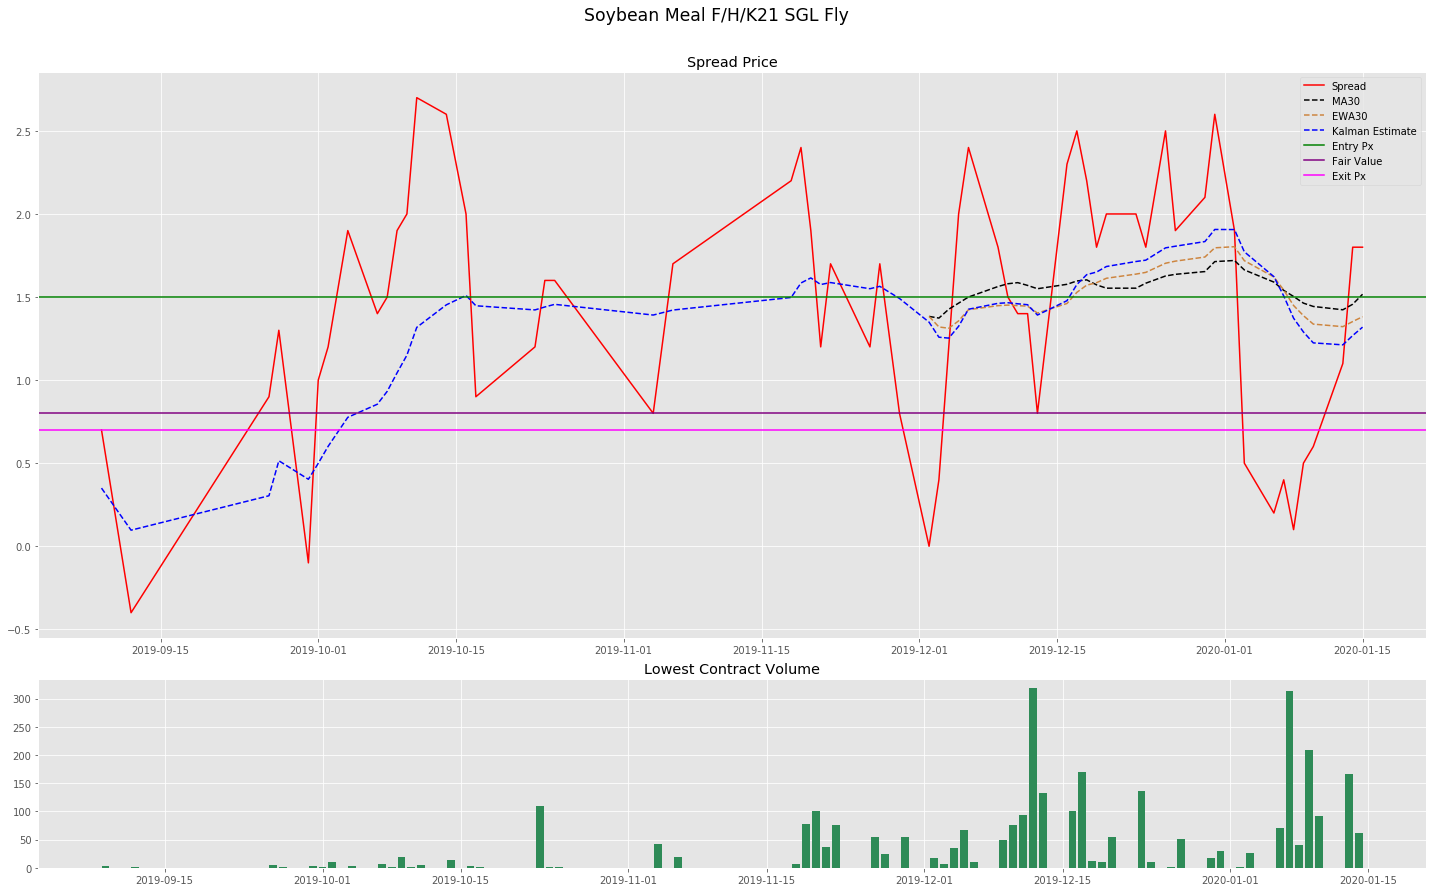

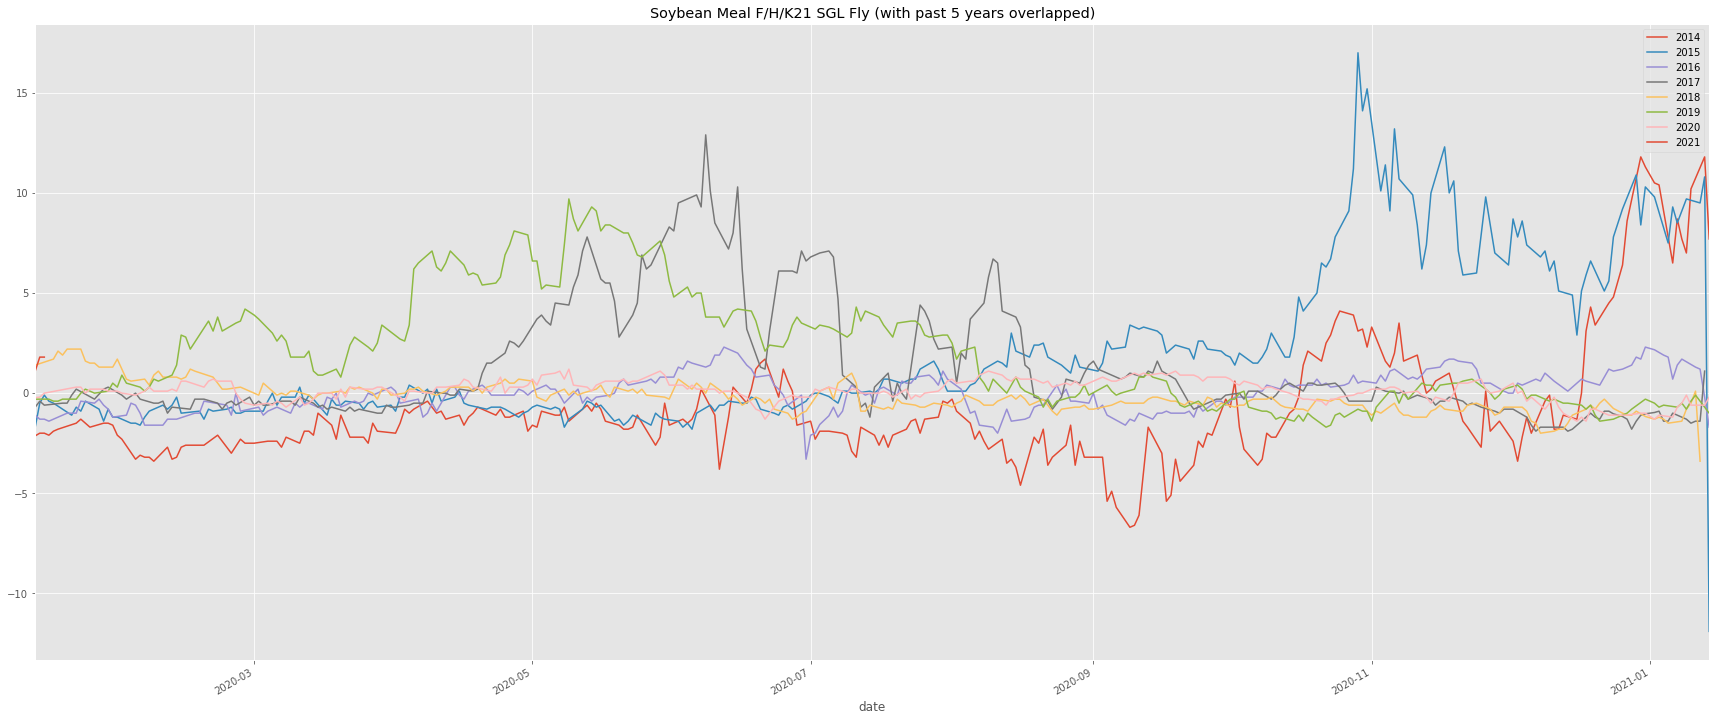

In [10]:
present_good_spread(0)

## #2 Natural Gas X/Z/F21 SGL Fly

'Backtest result of #2 Natural Gas X/Z/F21 SGL Fly'

Strategy  Win%  Lose%   WinΦ  LossΦ  Win_M  Loss_M  ProfitΦ   RRR    PF  \
1160       HP  68.2   31.8  230.0 -203.0  180.0  -240.0     92.0  12.3   2.4   
1161      DHP  77.6   20.7  336.0 -100.0  230.0   -70.0    240.0  71.8  12.6   
1162       MA  64.3   35.7  436.0  -80.0  380.0   -80.0    251.0   3.6   9.8   
1163        K  68.0   29.0  186.0 -173.0  130.0  -110.0     76.0   1.5   2.5   
1164      EWA  61.5   38.5  486.0 -160.0  430.0  -130.0    238.0   3.3   4.9   
1165   Kalman  75.0   25.0  162.0  -80.0  160.0   -80.0    101.0   inf   6.1   
1166     SISO  59.0   38.0  207.0 -147.0  140.0  -110.0     66.0   1.2   2.2   
1167     AIAO  55.7   42.6  212.0 -119.0  110.0   -70.0     68.0   1.5   2.3   

      Max_Drawdown    Best  Worst   A%  DaysΦ  Trades  
1160        -460.0   520.0 -310.0  0.4   61.2    22.0  
1161        -360.0  1400.0 -270.0  0.9   51.4    58.0  
1162       -1030.0   960.0 -190.0  0.2   38.5    14.0  
1163       -1140.0  1180.0 -900.0  0.7   35.5   100.0  
1164       -1030.0  1150.0 -280.0  0.2   45.8    13.0  
1165        -580.0   310.0 -120.0  0.5   47.1     8.0  
1166        -930.0  1250.0 -680.0  0.7   19.5   300.0  
1167        -740.0  1460.0 -690.0  0.7   19.9   235.0

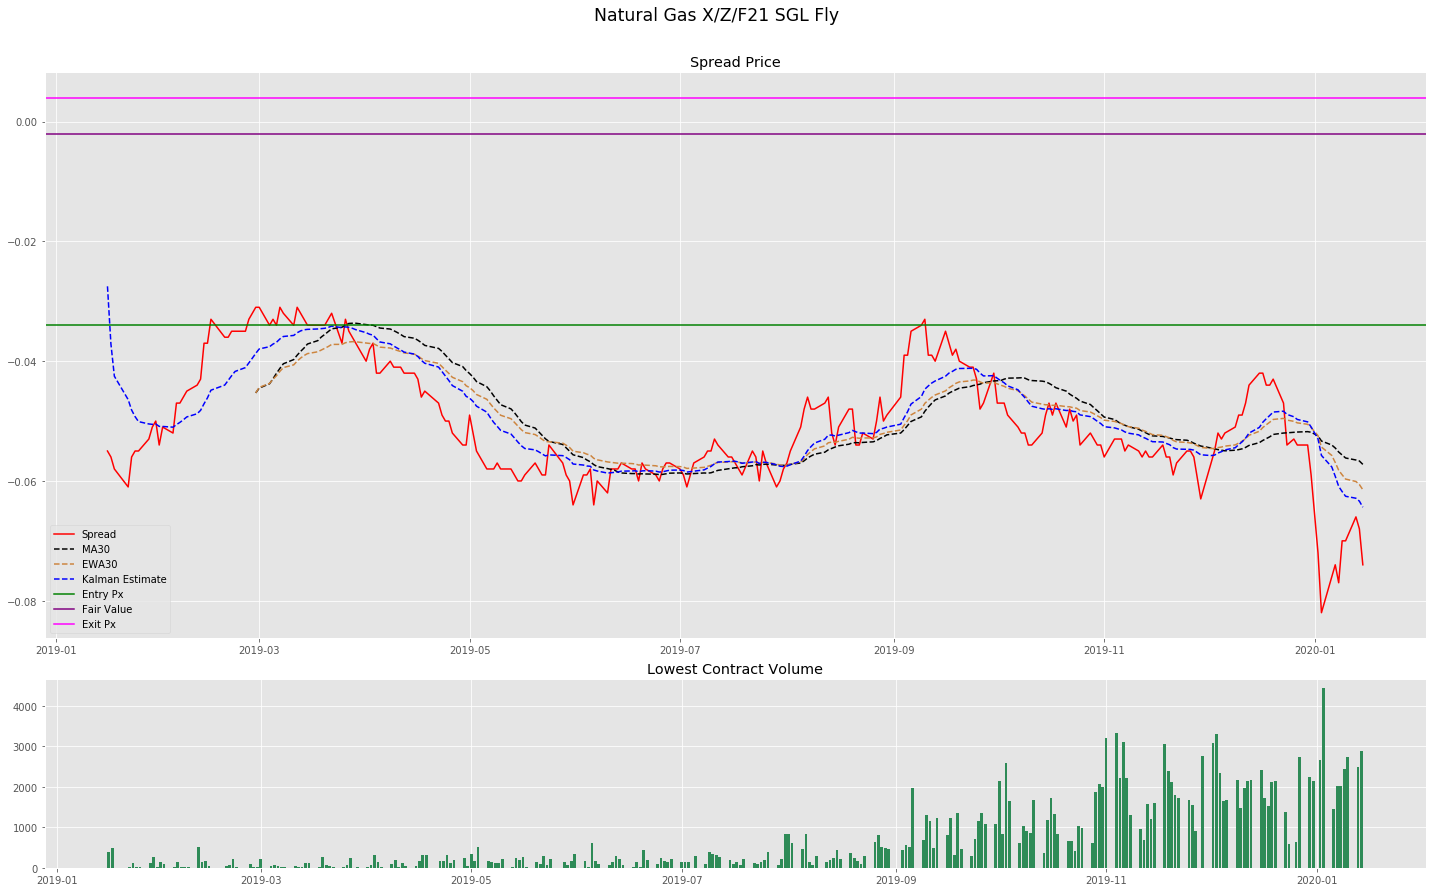

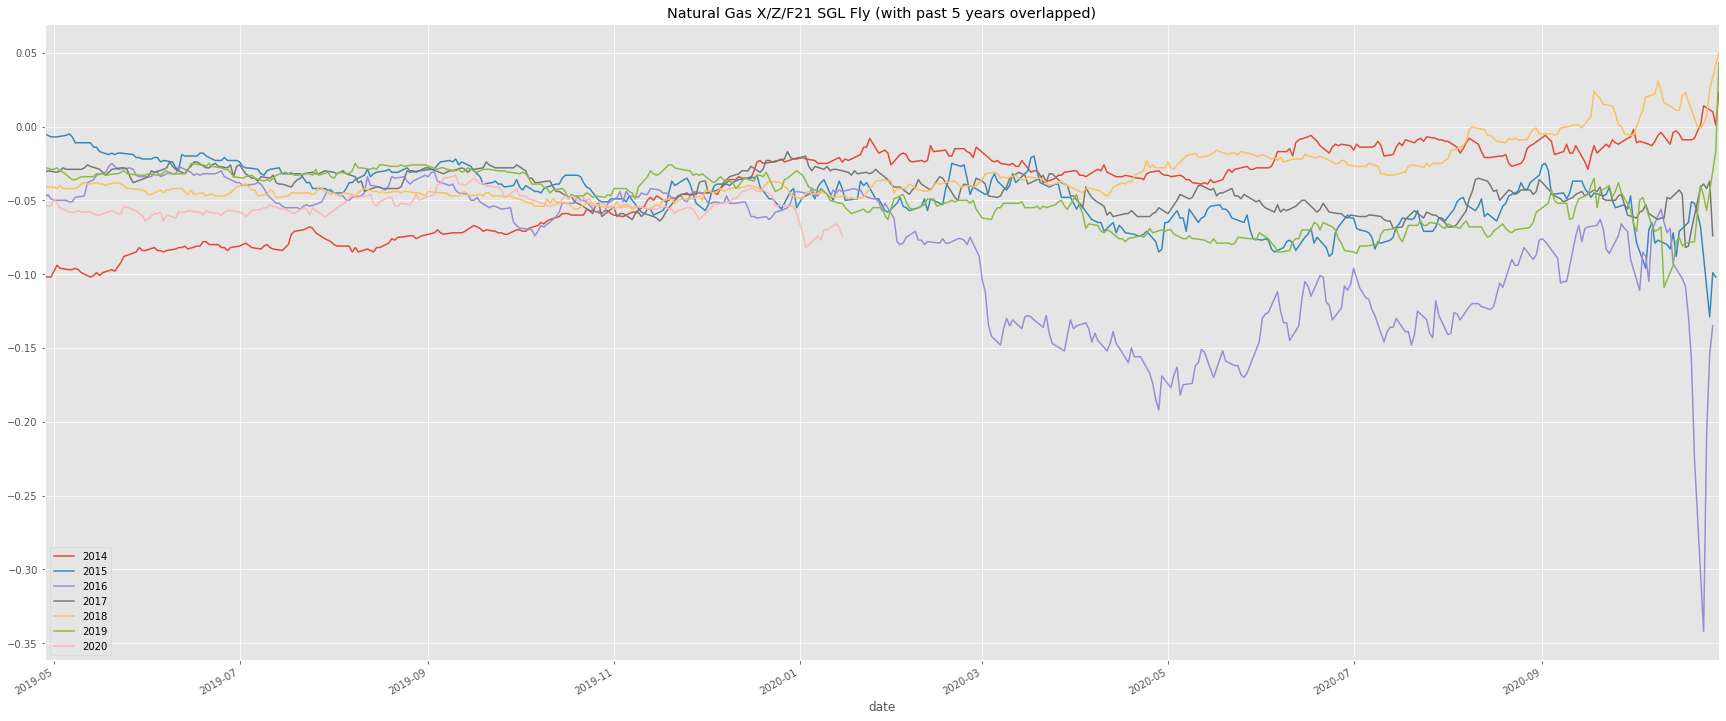

In [11]:
present_good_spread(1)

## #3 Natural Gas V/X/Z/F21 Condor

'Backtest result of #3 Natural Gas V/X/Z/F21 Condor'

Strategy  Win%  Lose%   WinΦ  LossΦ  Win_M  Loss_M  ProfitΦ   RRR   PF  \
1144       HP  73.8   24.6  253.0 -114.0  165.0  -105.0    159.0   inf  6.7   
1145      DHP  73.0   27.0  330.0 -113.0  200.0   -90.0    210.0  17.0  7.9   
1146       MA  70.6   29.4  523.0 -300.0  525.0  -230.0    281.0   inf  4.2   
1147        K  73.7   24.2  185.0 -241.0  120.0  -125.0     78.0   1.2  2.3   
1148      EWA  70.6   29.4  568.0 -278.0  620.0  -220.0    319.0   inf  4.9   
1149   Kalman  76.9   23.1  366.0 -177.0  245.0   -90.0    241.0   inf  6.9   
1150     SISO  56.1   39.8  222.0 -173.0  190.0  -100.0     56.0   1.3  1.8   
1151     AIAO  53.5   43.8  228.0 -175.0  160.0  -100.0     45.0   1.3  1.6   

      Max_Drawdown    Best  Worst   A%  DaysΦ  Trades  
1144        -430.0  1410.0 -250.0  0.8   56.4    65.0  
1145        -520.0  1210.0 -340.0  0.8   51.3    74.0  
1146       -1100.0   990.0 -510.0  0.3   28.4    17.0  
1147       -1300.0  1060.0 -880.0  0.8   34.1    99.0  
1148       -1100.0  1070.0 -510.0  0.3   30.9    17.0  
1149        -520.0   990.0 -360.0  0.5   32.2    13.0  
1150        -950.0   960.0 -700.0  0.6   19.3   294.0  
1151        -950.0  1290.0 -850.0  0.7   19.5   226.0

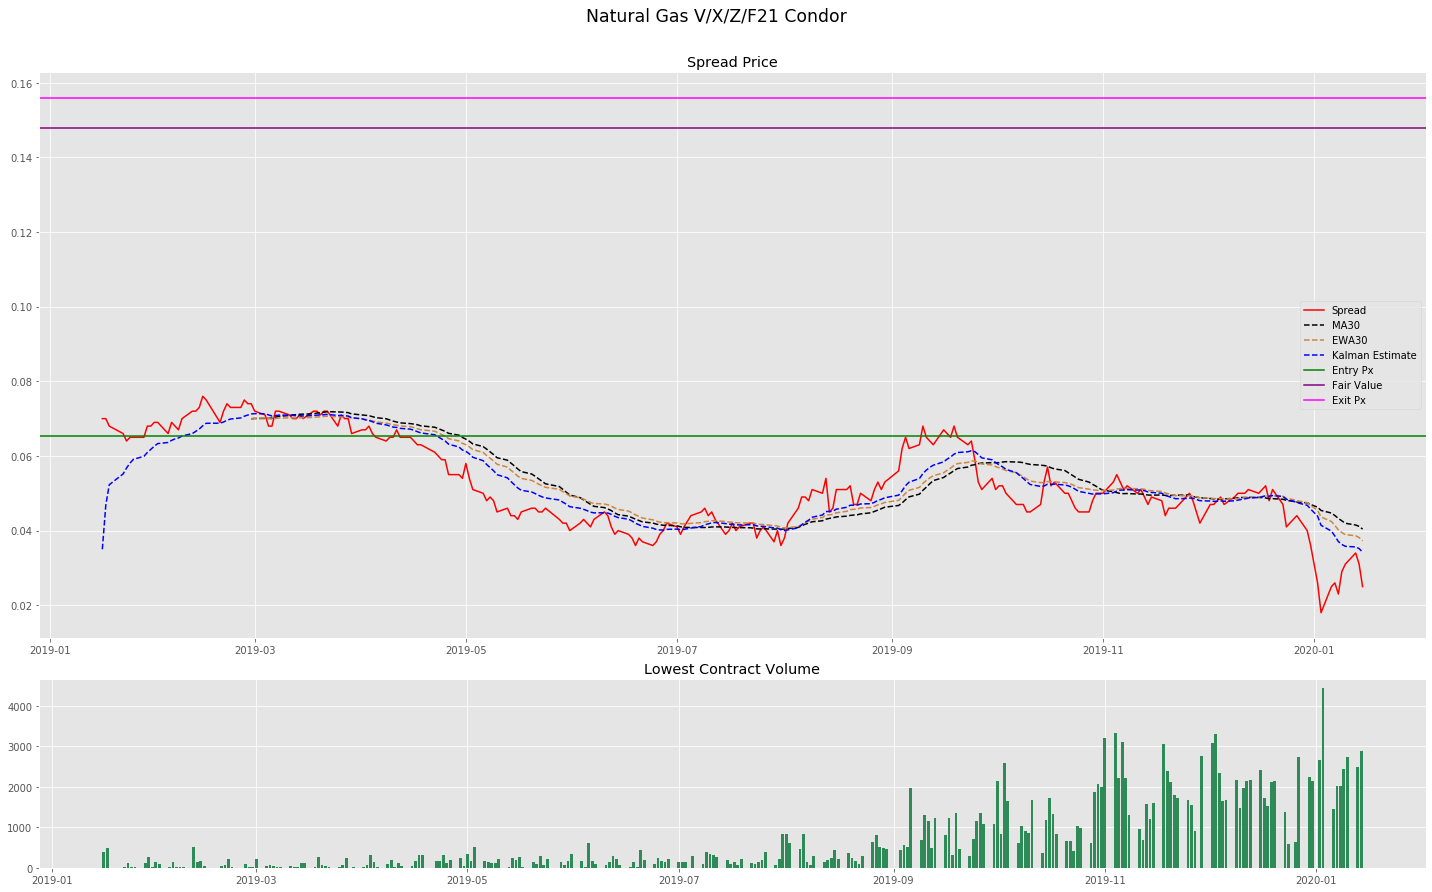

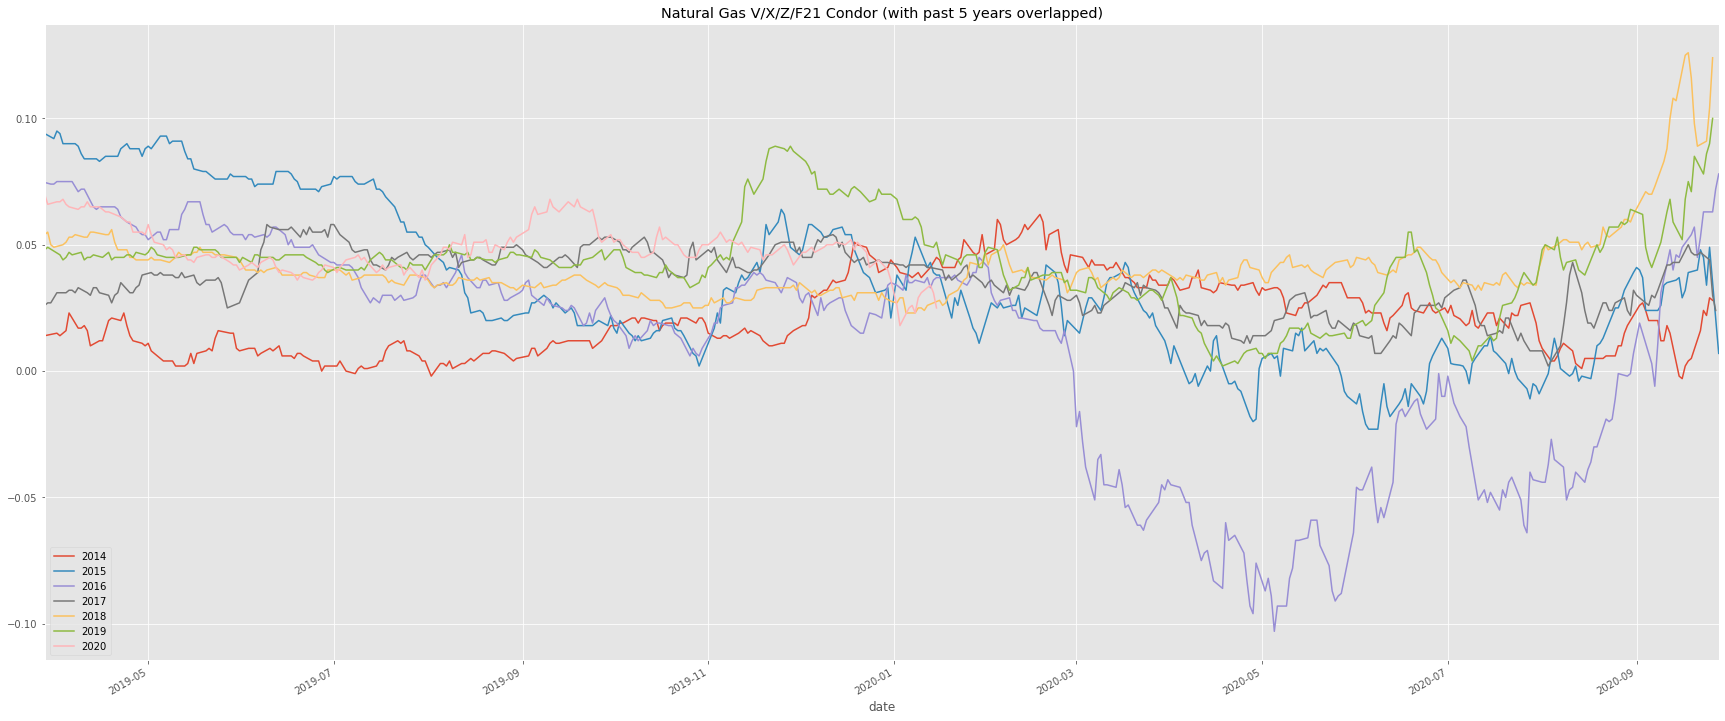

In [12]:
present_good_spread(2)

## #4 Heating Oil Z/F/G/H21 Condor

'Backtest result of #4 Heating Oil Z/F/G/H21 Condor'

Strategy  Win%  Lose%    WinΦ   LossΦ  Win_M  Loss_M  ProfitΦ   RRR    PF  \
272       HP  65.5   34.5  223.86 -181.86  205.8  -117.6    84.00  14.1   2.3   
273      DHP  78.3   21.7  204.12  -81.48  172.2   -75.6   142.38   inf   9.1   
274       MA  84.2   15.8  256.62  -72.66  256.2   -63.0   204.54   inf  18.8   
275        K  64.5   32.9  137.76 -134.40  126.0  -117.6    44.52   1.6   2.0   
276      EWA  81.0   14.3  240.24  -89.46  256.2  -117.6   181.44   inf  15.2   
277   Kalman  66.7   33.3  221.34 -135.66  231.0  -105.0   102.48   7.7   3.3   
278     SISO  50.0   45.0  116.76 -127.26  105.0   -92.4     1.26   1.0   1.0   
279     AIAO  53.0   42.3  126.00 -121.38  113.4   -96.6    15.54   1.3   1.3   

     Max_Drawdown   Best  Worst   A%  DaysΦ  Trades  
272        -541.8  457.8 -495.6  0.6   41.7    29.0  
273        -205.8  810.6 -147.0  1.0   49.4    60.0  
274        -449.4  508.2 -117.6  0.9   29.1    19.0  
275        -537.6  306.6 -399.0  0.7   36.2    76.0  
276        -449.4  453.6 -147.0  0.8   31.3    21.0  
277        -588.0  642.6 -319.2  0.8   31.5    30.0  
278        -449.4  361.2 -436.8  0.5   19.9   180.0  
279        -449.4  382.2 -436.8  0.5   20.1   149.0

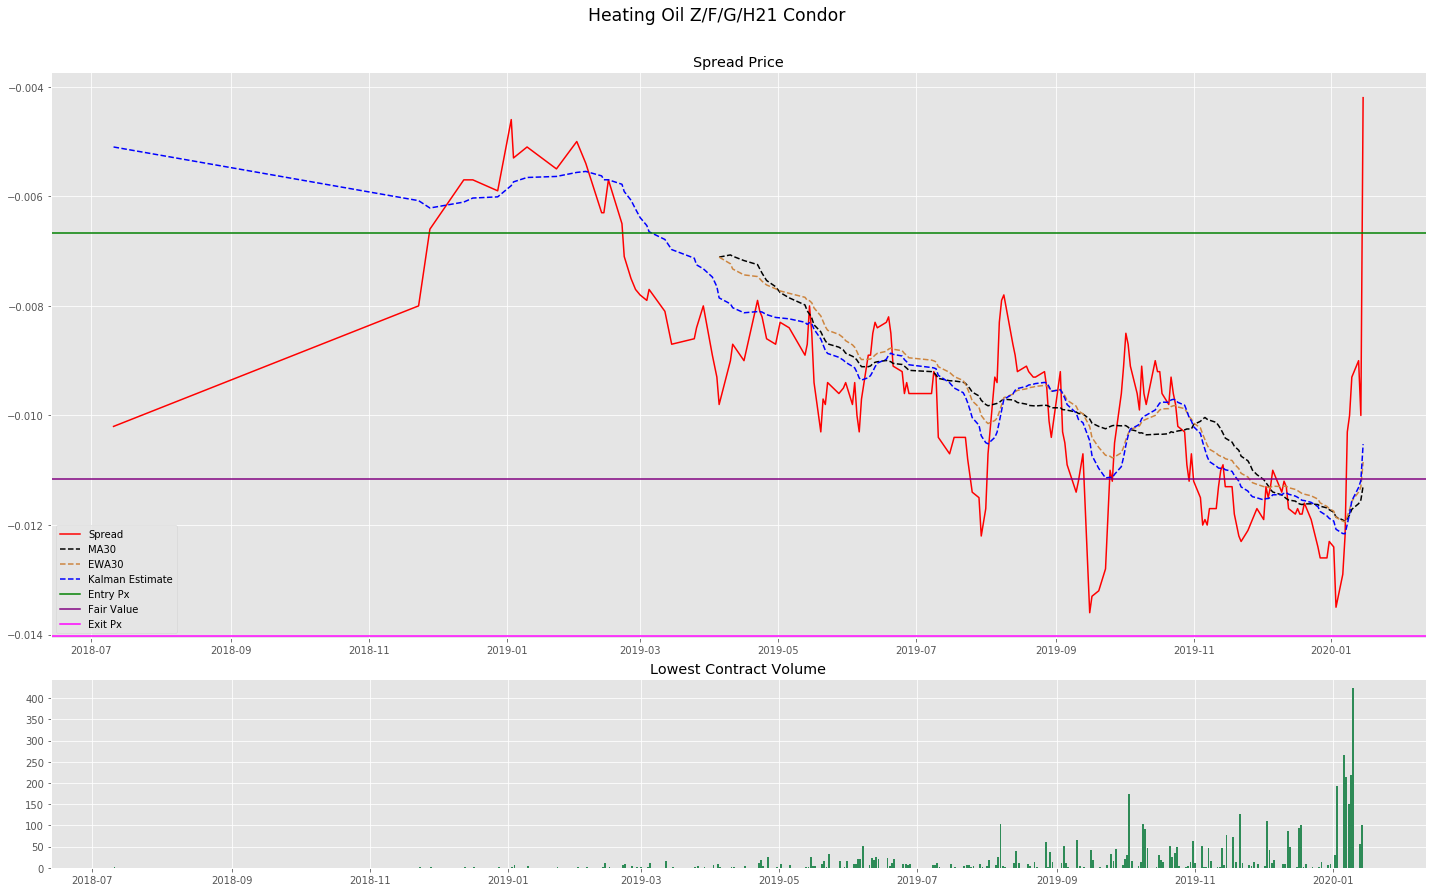

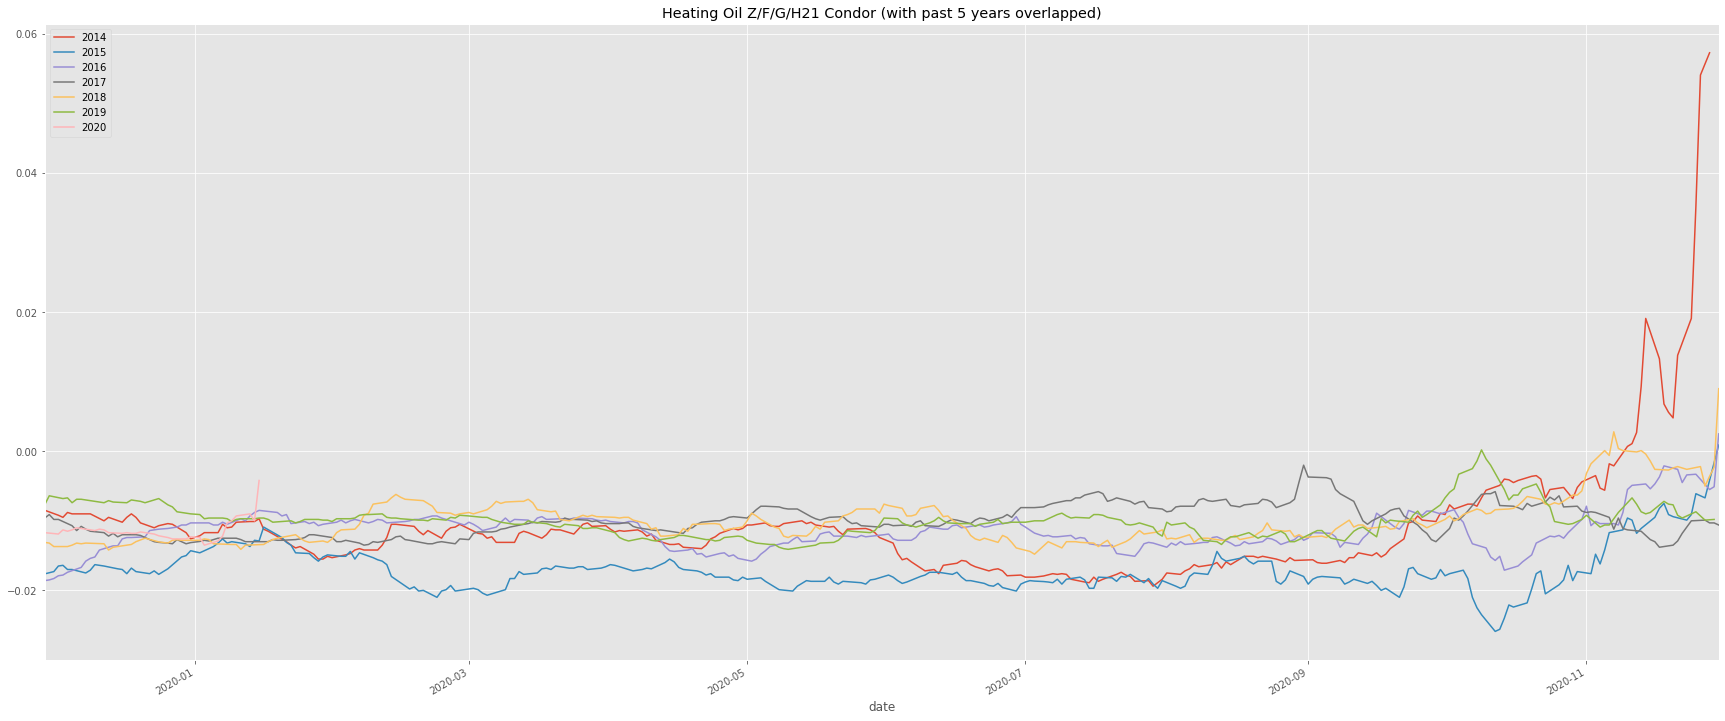

In [13]:
present_good_spread(3)

## #5 Heating Oil X/Z/F/G21 Condor

'Backtest result of #5 Heating Oil X/Z/F/G21 Condor'

Strategy  Win%  Lose%    WinΦ  LossΦ  Win_M  Loss_M  ProfitΦ  RRR    PF  \
248       HP  69.7   27.3  139.86 -80.64  117.6   -67.2    75.60  6.3   4.4   
249      DHP  84.1   15.9  188.58 -38.22  172.2   -35.7   152.46  inf  26.1   
250       MA  88.2   11.8  177.66 -29.40  117.6   -29.4   153.30  inf  45.4   
251        K  78.8   20.0  119.70 -55.02  105.0   -37.8    83.16  4.4   8.6   
252      EWA  92.0    8.0  152.04 -29.40  117.6   -29.4   137.34  inf  59.4   
253   Kalman  88.0   12.0  163.80 -51.66  151.2   -46.2   137.76  inf  23.2   
254     SISO  62.1   37.9   89.04 -92.40   67.2   -79.8    20.58  0.9   1.6   
255     AIAO  60.5   38.8   96.60 -72.66   75.6   -58.8    30.24  1.4   2.1   

     Max_Drawdown   Best  Worst   A%  DaysΦ  Trades  
248        -491.4  554.4 -163.8  0.6   41.7    33.0  
249        -155.4  457.8  -75.6  1.0   42.3    63.0  
250        -239.4  609.0  -37.8  0.6   26.9    17.0  
251        -239.4  352.8 -134.4  1.0   29.3    80.0  
252        -239.4  537.6  -37.8  0.8   32.5    25.0  
253        -315.0  537.6  -71.4  0.8   29.4    25.0  
254        -474.6  298.2 -474.6  0.5   19.0   198.0  
255        -474.6  554.4 -474.6  0.7   19.3   152.0

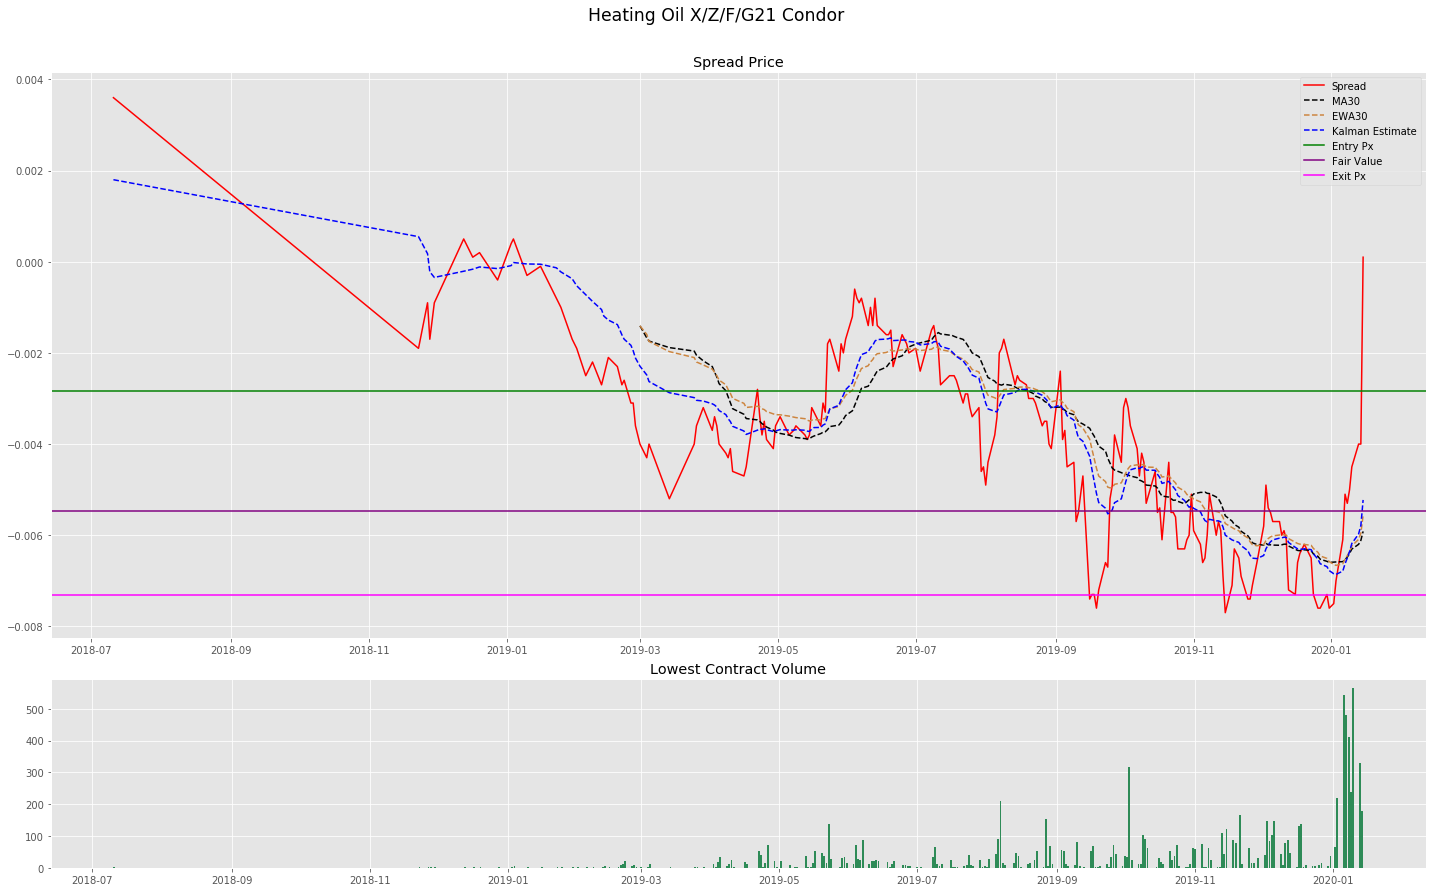

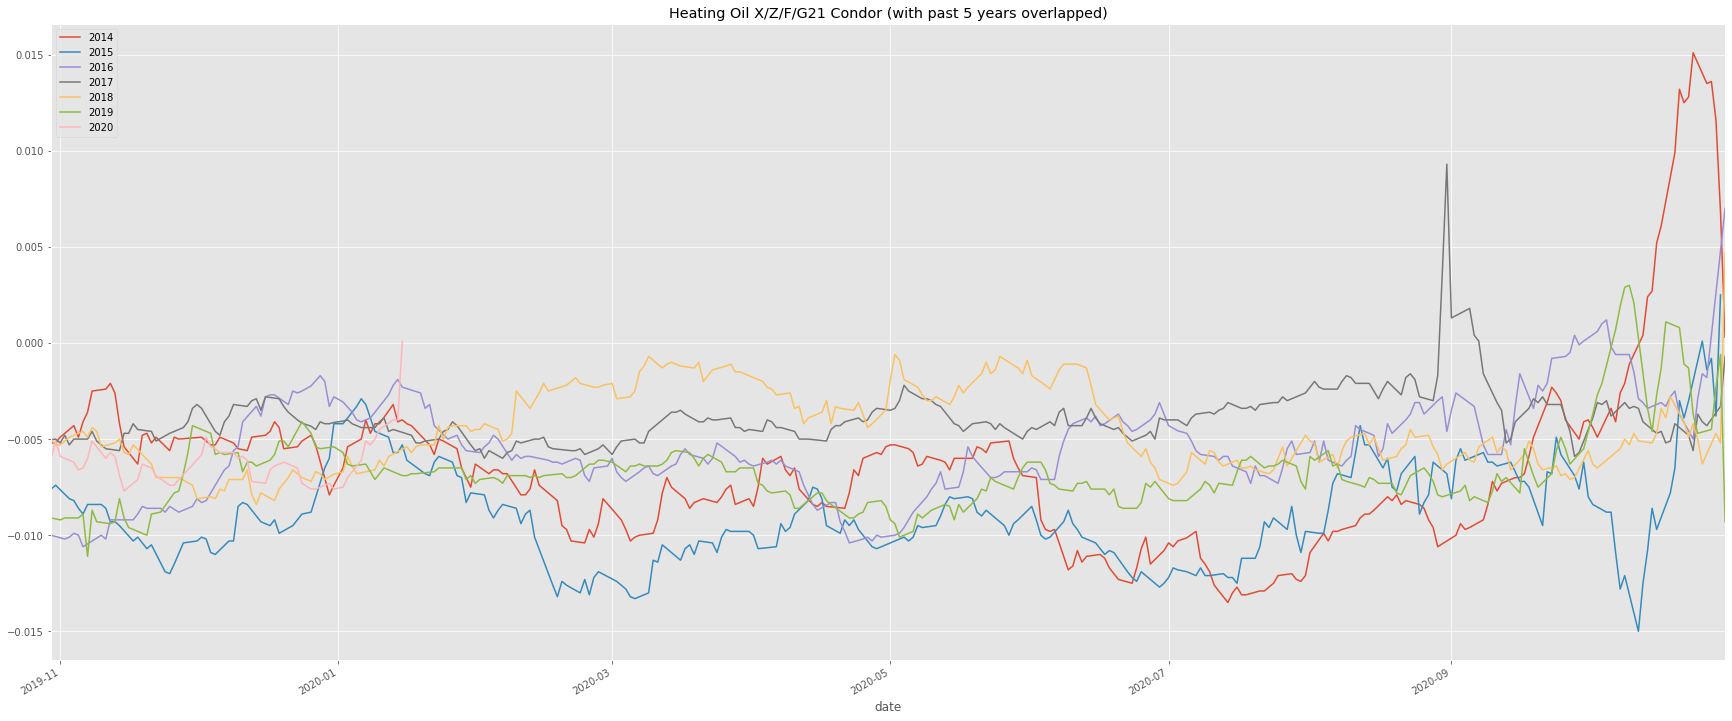

In [14]:
present_good_spread(4)

## #6 Lean Hogs Q/V/Z20 SGL Fly

'Backtest result of #6 Lean Hogs Q/V/Z20 SGL Fly'

Strategy  Win%  Lose%    WinΦ  LossΦ   Win_M  Loss_M  ProfitΦ  RRR  \
1816       HP  89.6   10.4  1199.0 -164.0  1270.0  -110.0   1057.0  inf   
1817      DHP  97.3    2.7  1172.0  -45.0  1125.0   -45.0   1139.0  inf   
1818       MA  76.2   23.8  1175.0 -449.0  1205.0  -450.0    788.0  3.6   
1819        K  81.2   18.8   974.0 -539.0   750.0  -450.0    690.0  3.4   
1820      EWA  77.9   22.1  1090.0 -445.0  1170.0  -450.0    751.0  3.8   
1821   Kalman  81.8   18.2   932.0 -537.0   840.0  -400.0    665.0  3.9   
1822     SISO  68.3   31.7   710.0 -352.0   600.0  -255.0    373.0  2.7   
1823     AIAO  70.5   29.5   747.0 -374.0   520.0  -325.0    417.0  2.8   

         PF  Max_Drawdown    Best   Worst   A%  DaysΦ  Trades  
1816   62.9       -3000.0  3550.0  -450.0  0.9   32.5    48.0  
1817  937.9       -2660.0  2860.0   -70.0  1.0   23.0    74.0  
1818    8.4       -2390.0  3560.0 -2380.0  0.9   25.0    63.0  
1819    7.8       -2430.0  5660.0 -1730.0  0.9   26.0    80.0  
1820    8.6       -2380.0  2990.0 -2380.0  0.9   24.6    68.0  
1821    7.8       -2660.0  2960.0 -2380.0  0.7   22.9    66.0  
1822    4.3       -2660.0  3000.0 -1370.0  0.9   18.0   189.0  
1823    4.8       -2030.0  3960.0 -1370.0  1.0   18.8   129.0

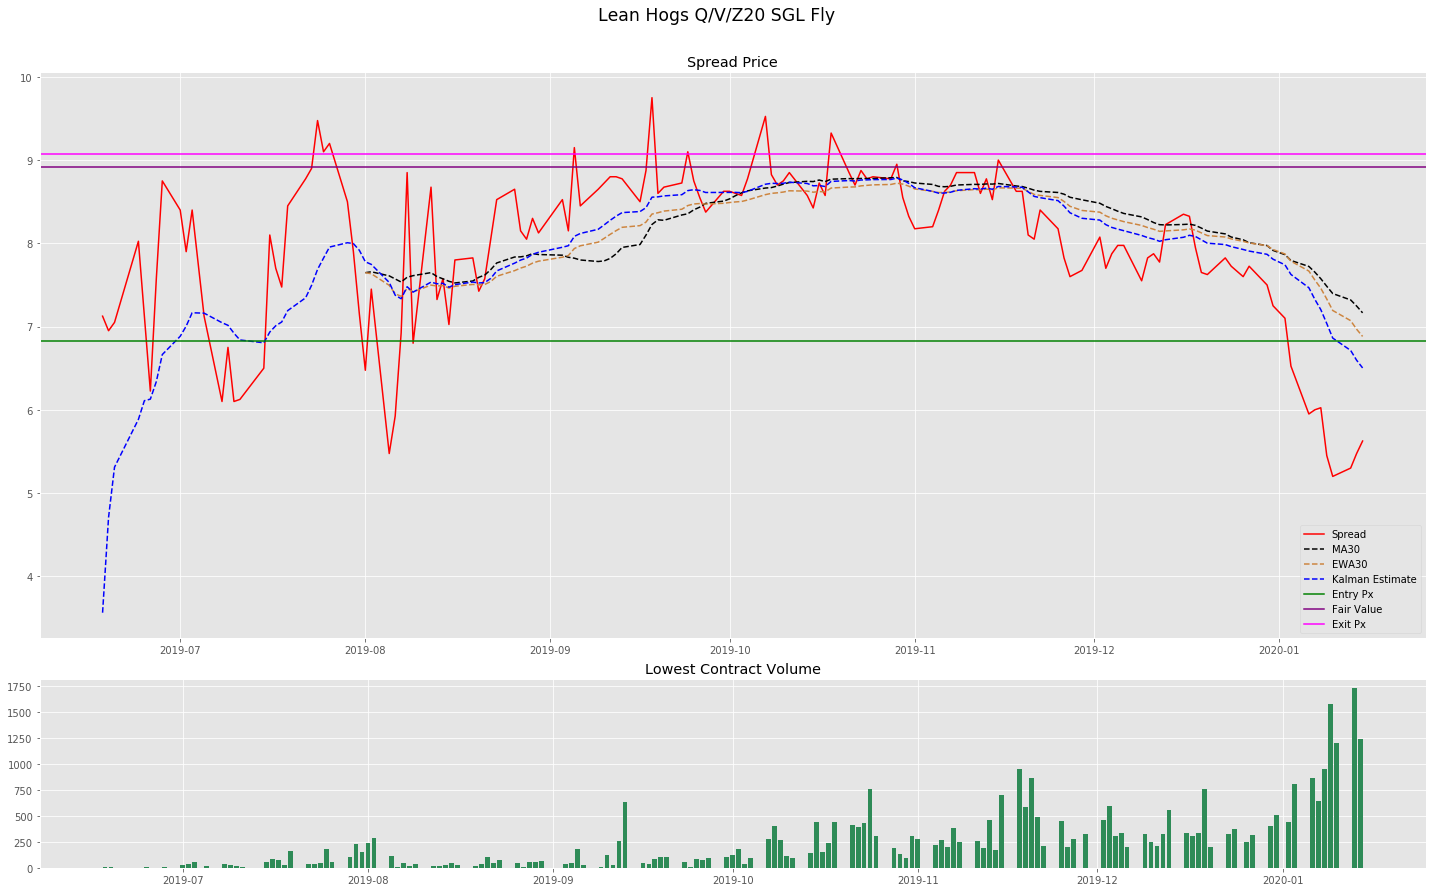

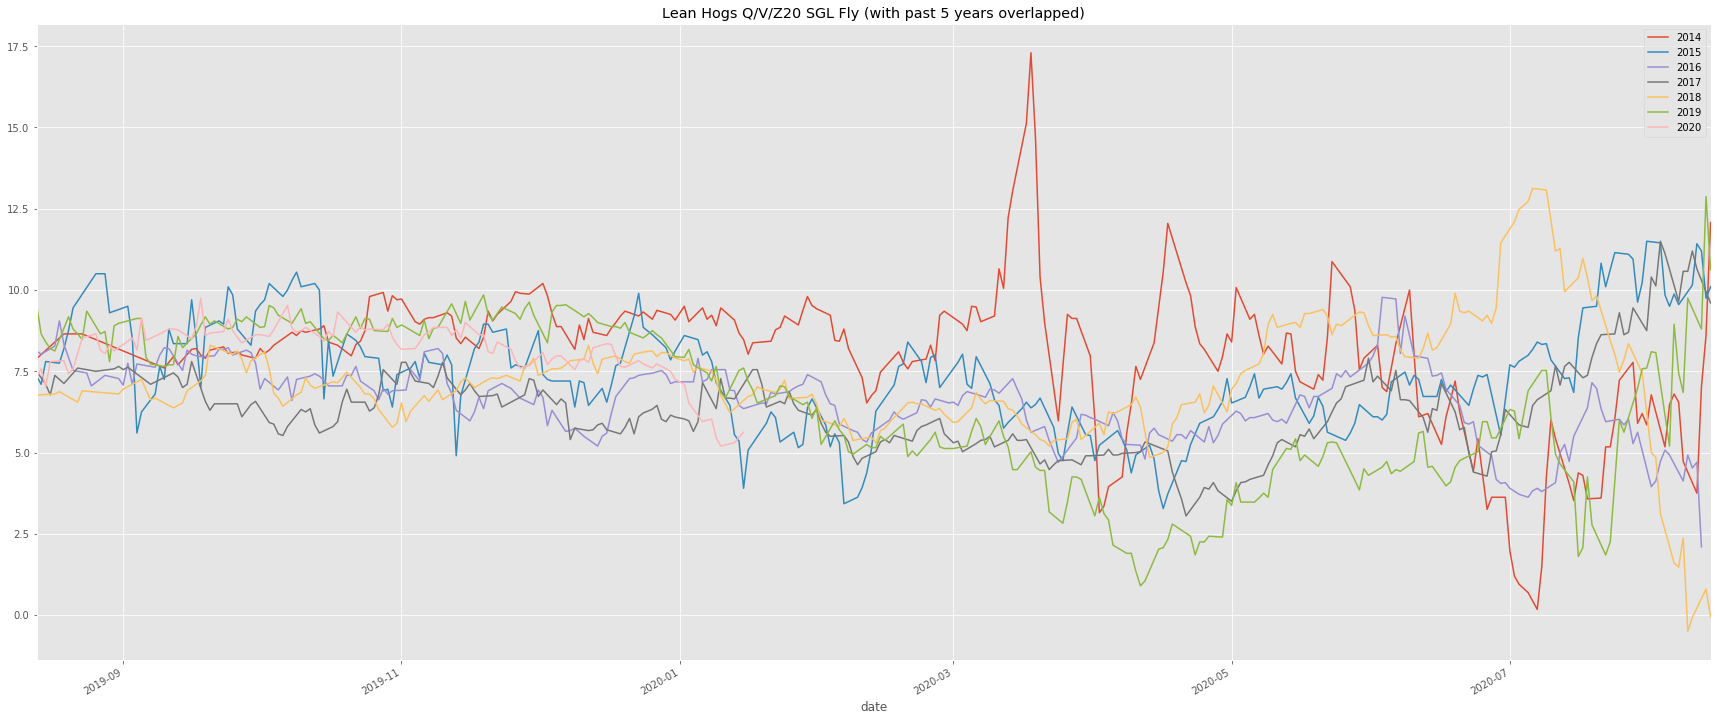

In [15]:
present_good_spread(5)

## #7 Feeder Cattle Q/U/X20 SGL Fly

'Backtest result of #7 Feeder Cattle Q/U/X20 SGL Fly'

Strategy  Win%  Lose%    WinΦ   LossΦ    Win_M  Loss_M  ProfitΦ   RRR  \
1936       HP  85.7   14.3  922.50 -187.50  1018.75 -137.50   763.75   inf   
1937      DHP  94.4    5.6  855.00 -250.00   862.50 -200.00   793.75   inf   
1938       MA  91.5    8.5  685.00 -197.50   687.50 -150.00   610.00   inf   
1939        K  88.9   11.1  581.25 -277.50   587.50 -275.00   486.25   inf   
1940      EWA  93.5    6.5  728.75 -291.25   812.50 -362.50   661.25   inf   
1941   Kalman  90.7    9.3  632.50 -215.00   687.50 -137.50   555.00   inf   
1942     SISO  82.9   17.1  400.00 -240.00   375.00 -206.25   290.00  95.8   
1943     AIAO  84.1   14.5  446.25 -207.50   368.75 -218.75   345.00  26.7   

        PF  Max_Drawdown    Best  Worst   A%  DaysΦ  Trades  
1936  29.5       -1612.5  1587.5 -450.0  0.8   37.9    28.0  
1937  58.2        -800.0  1750.0 -450.0  1.0   19.1    54.0  
1938  37.4       -1087.5  1912.5 -412.5  1.0   23.4    47.0  
1939  16.8       -1262.5  1200.0 -600.0  1.0   21.9    54.0  
1940  35.8       -1087.5  1912.5 -412.5  1.0   18.7    46.0  
1941  28.8       -1612.5  1350.0 -412.5  0.9   18.6    54.0  
1942   8.1       -1087.5   937.5 -600.0  1.0   17.9   105.0  
1943  12.5       -1087.5  1262.5 -600.0  1.0   17.7    69.0

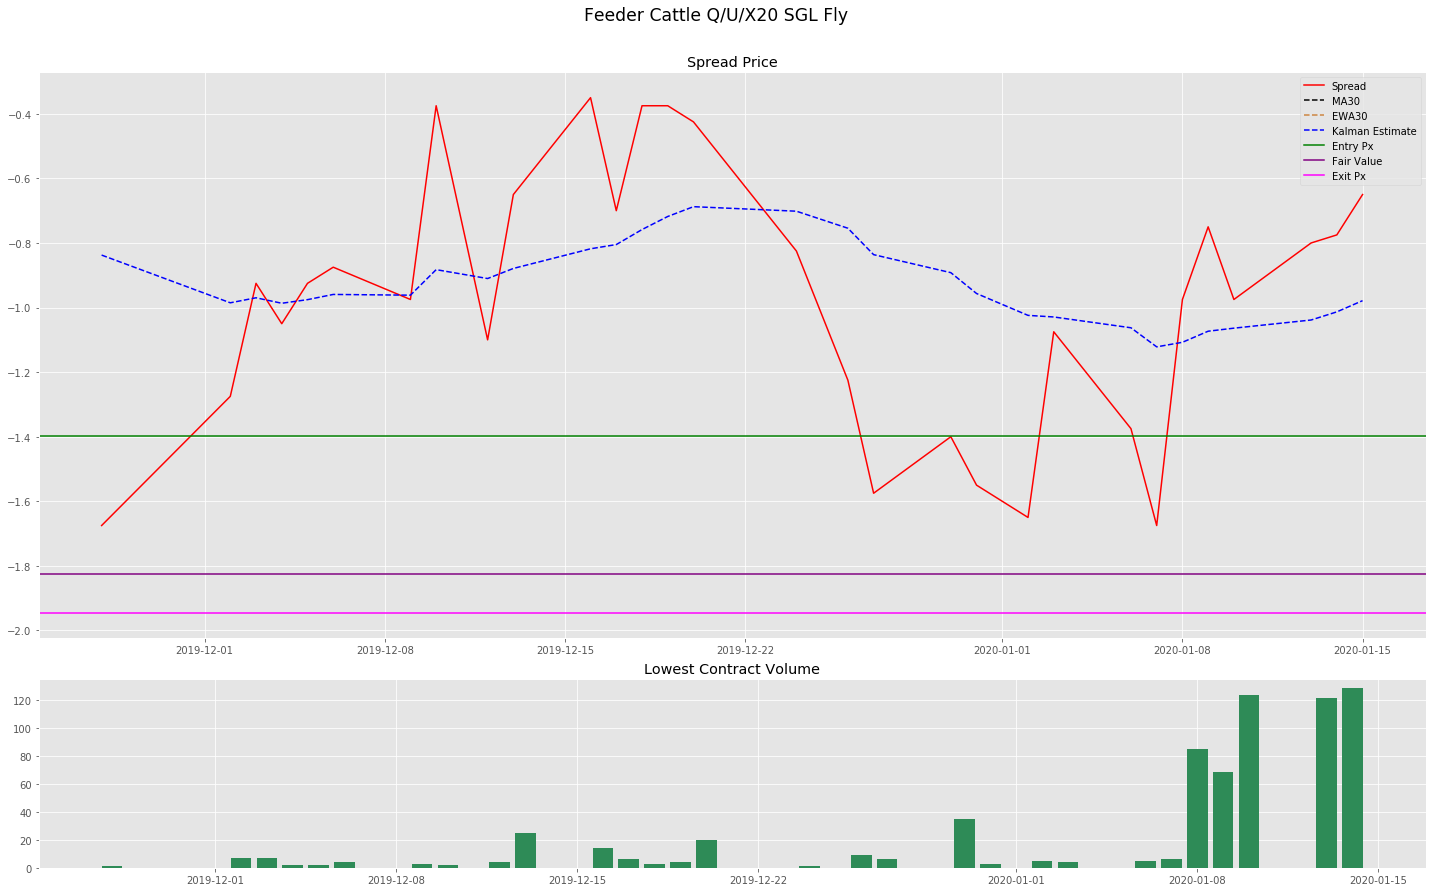

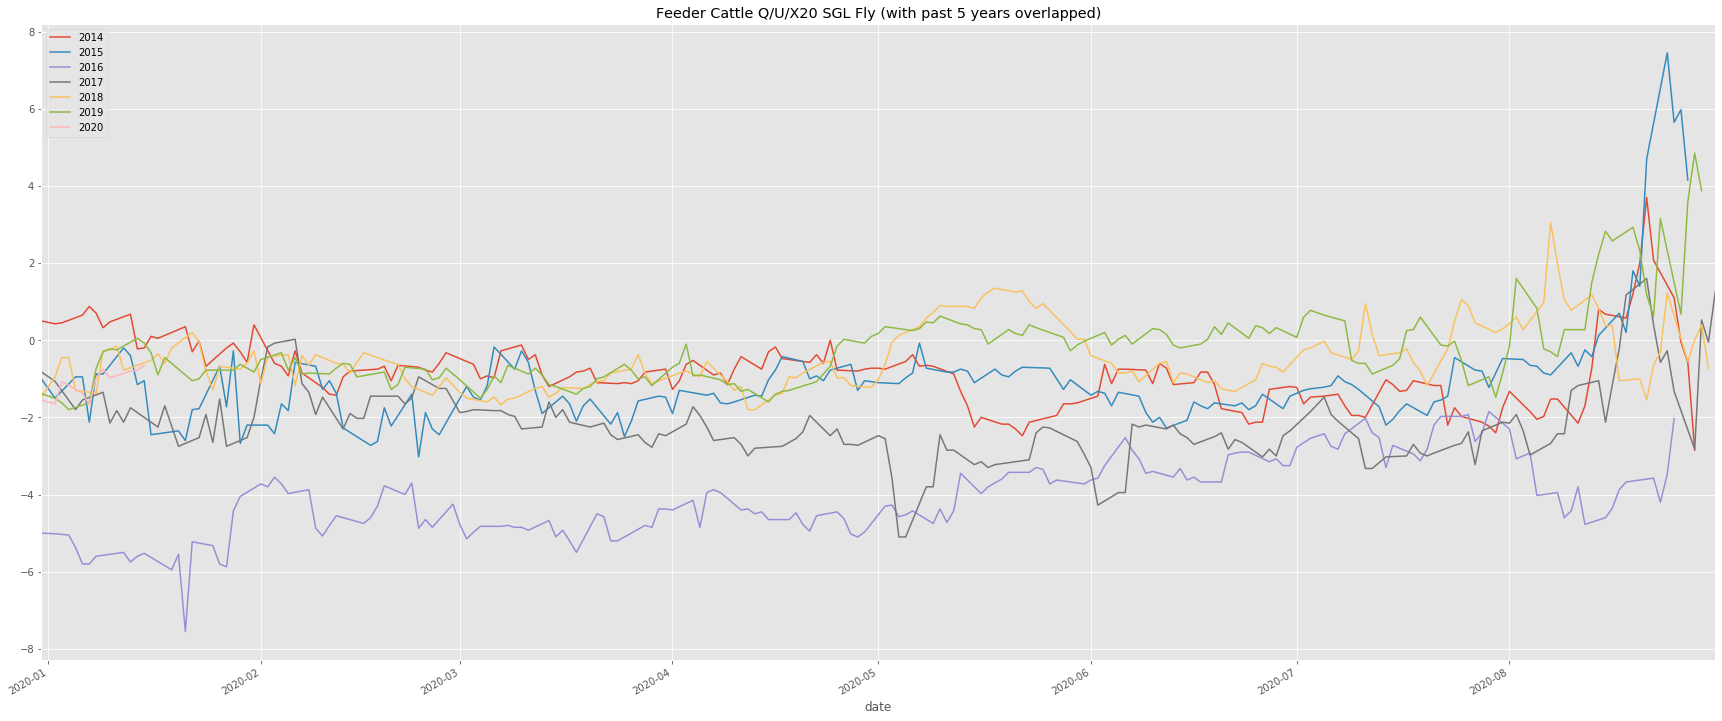

In [16]:
present_good_spread(6)

## #8 Live Cattle Q/V/Z20 SGL Fly

'Backtest result of #8 Live Cattle Q/V/Z20 SGL Fly'

Strategy  Win%  Lose%   WinΦ  LossΦ  Win_M  Loss_M  ProfitΦ  RRR    PF  \
1600       HP  41.9   58.1  568.0 -299.0  570.0  -285.0     64.0  2.7   1.4   
1601      DHP  83.6   16.4  804.0 -242.0  780.0  -150.0    632.0  inf  16.9   
1602       MA  72.9   27.1  558.0 -301.0  530.0  -290.0    325.0  2.8   5.0   
1603        K  76.2   23.8  443.0 -315.0  380.0  -230.0    263.0  1.9   4.5   
1604      EWA  70.3   29.7  600.0 -294.0  560.0  -270.0    335.0  3.8   4.8   
1605   Kalman  75.7   24.3  551.0 -271.0  540.0  -270.0    351.0  2.3   6.3   
1606     SISO  61.9   38.1  357.0 -322.0  320.0  -225.0     99.0  1.5   1.8   
1607     AIAO  57.5   41.8  415.0 -288.0  390.0  -220.0    118.0  1.6   2.0   

      Max_Drawdown    Best   Worst   A%  DaysΦ  Trades  
1600       -1780.0  1000.0  -900.0  0.5   44.3    31.0  
1601        -880.0  2160.0  -670.0  1.0   35.5    61.0  
1602       -1420.0  1240.0  -580.0  0.8   29.0    70.0  
1603       -1520.0  1230.0  -850.0  0.9   31.8    80.0  
1604       -1400.0  1370.0  -640.0  0.8   27.5    64.0  
1605       -1420.0  1240.0  -640.0  0.8   21.3    70.0  
1606       -1720.0  1490.0 -1570.0  0.9   18.8   189.0  
1607       -1720.0  1860.0 -1570.0  0.8   19.6   134.0

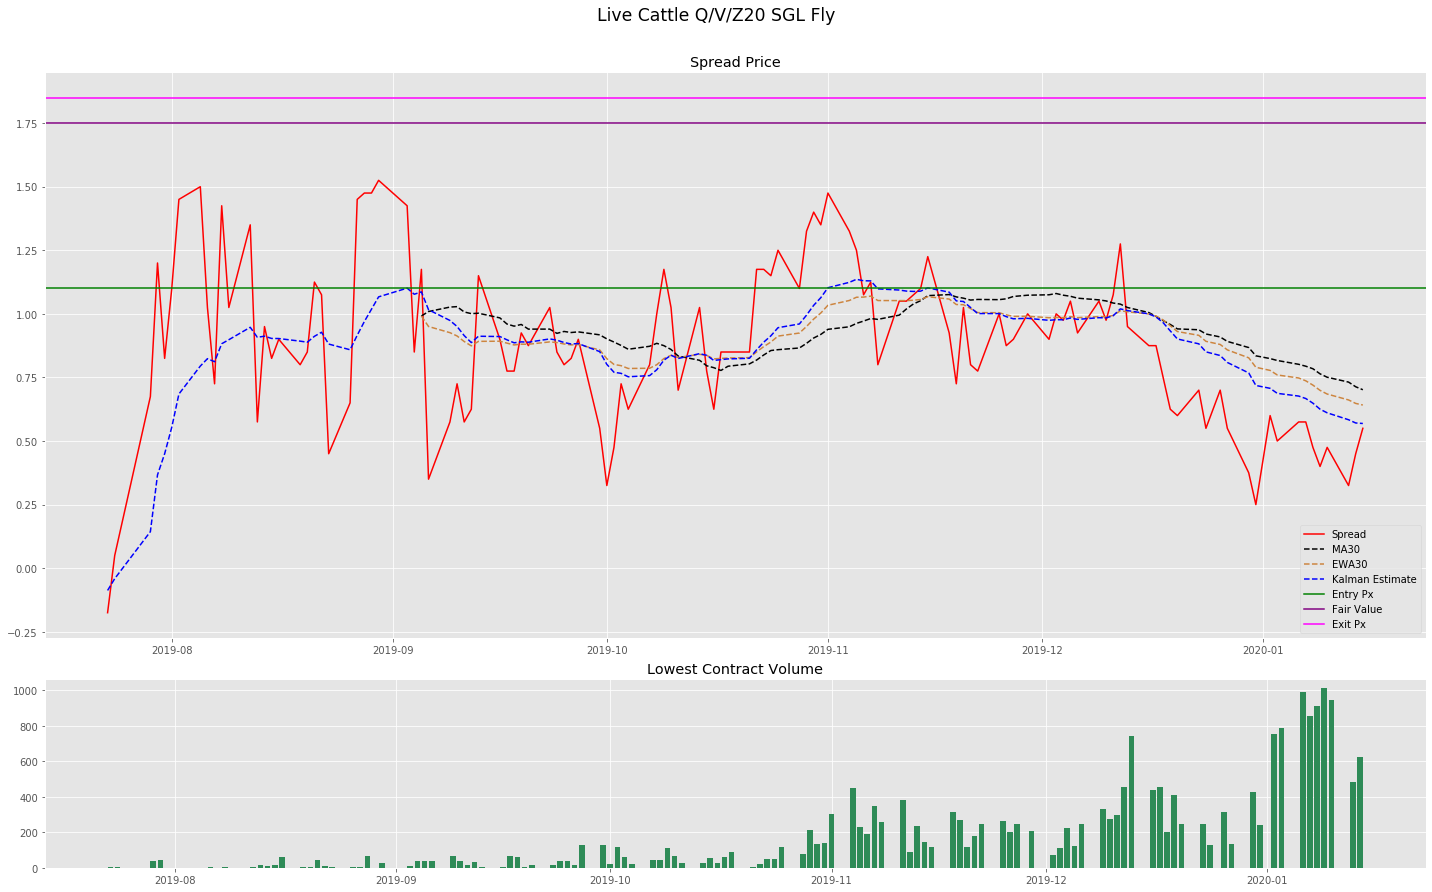

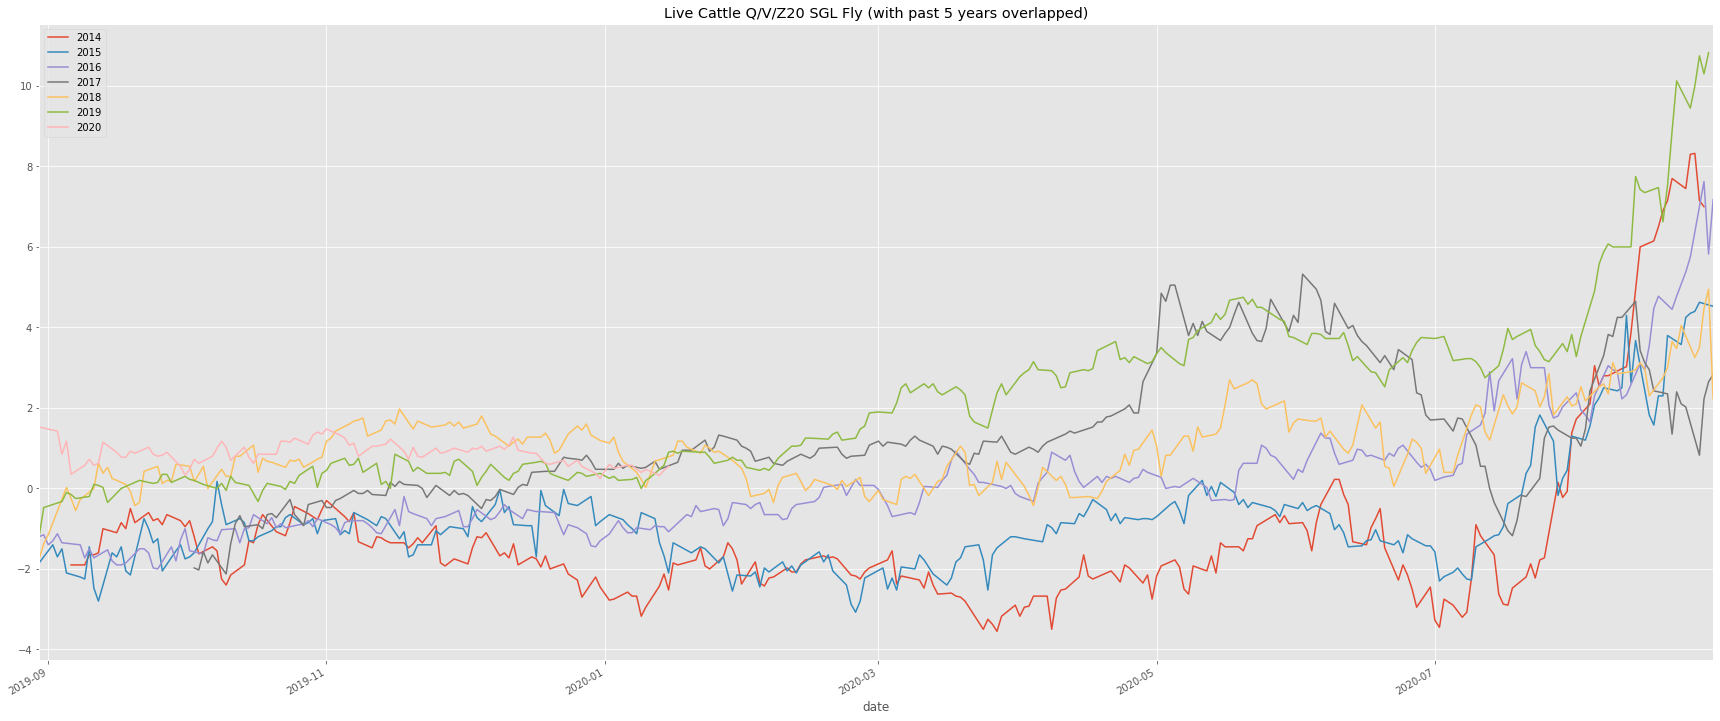

In [17]:
present_good_spread(7)

## #9 Live Cattle Q/V/Z/G21 Condor

'Backtest result of #9 Live Cattle Q/V/Z/G21 Condor'

Strategy  Win%  Lose%   WinΦ  LossΦ  Win_M  Loss_M  ProfitΦ  RRR   PF  \
1608       HP  53.6   46.4  667.0 -422.0  420.0  -210.0    161.0  inf  1.8   
1609      DHP  78.8   21.2  643.0 -267.0  460.0  -200.0    450.0  inf  9.0   
1610       MA  69.6   30.4  507.0 -311.0  540.0  -240.0    259.0  2.6  3.7   
1611        K  69.6   29.0  488.0 -456.0  460.0  -270.0    207.0  2.0  2.6   
1612      EWA  70.7   29.3  565.0 -302.0  560.0  -220.0    311.0  2.7  4.5   
1613   Kalman  74.0   26.0  503.0 -343.0  500.0  -300.0    283.0  2.0  4.2   
1614     SISO  62.5   37.5  385.0 -301.0  310.0  -240.0    128.0  1.7  2.1   
1615     AIAO  61.0   39.0  367.0 -348.0  315.0  -250.0     88.0  1.2  1.7   

      Max_Drawdown    Best   Worst   A%  DaysΦ  Trades  
1608       -1760.0  1970.0 -1160.0  0.5   48.3    28.0  
1609        -660.0  2420.0  -720.0  1.0   40.2    52.0  
1610       -1330.0  1160.0 -1050.0  1.0   30.0    56.0  
1611       -1690.0  1130.0 -1430.0  0.8   31.0    69.0  
1612       -1280.0  1060.0 -1050.0  0.9   28.4    58.0  
1613       -1330.0   980.0 -1050.0  0.8   23.3    73.0  
1614       -1490.0  1450.0 -1190.0  0.7   18.8   168.0  
1615       -1490.0  1450.0 -1350.0  0.7   19.3   118.0

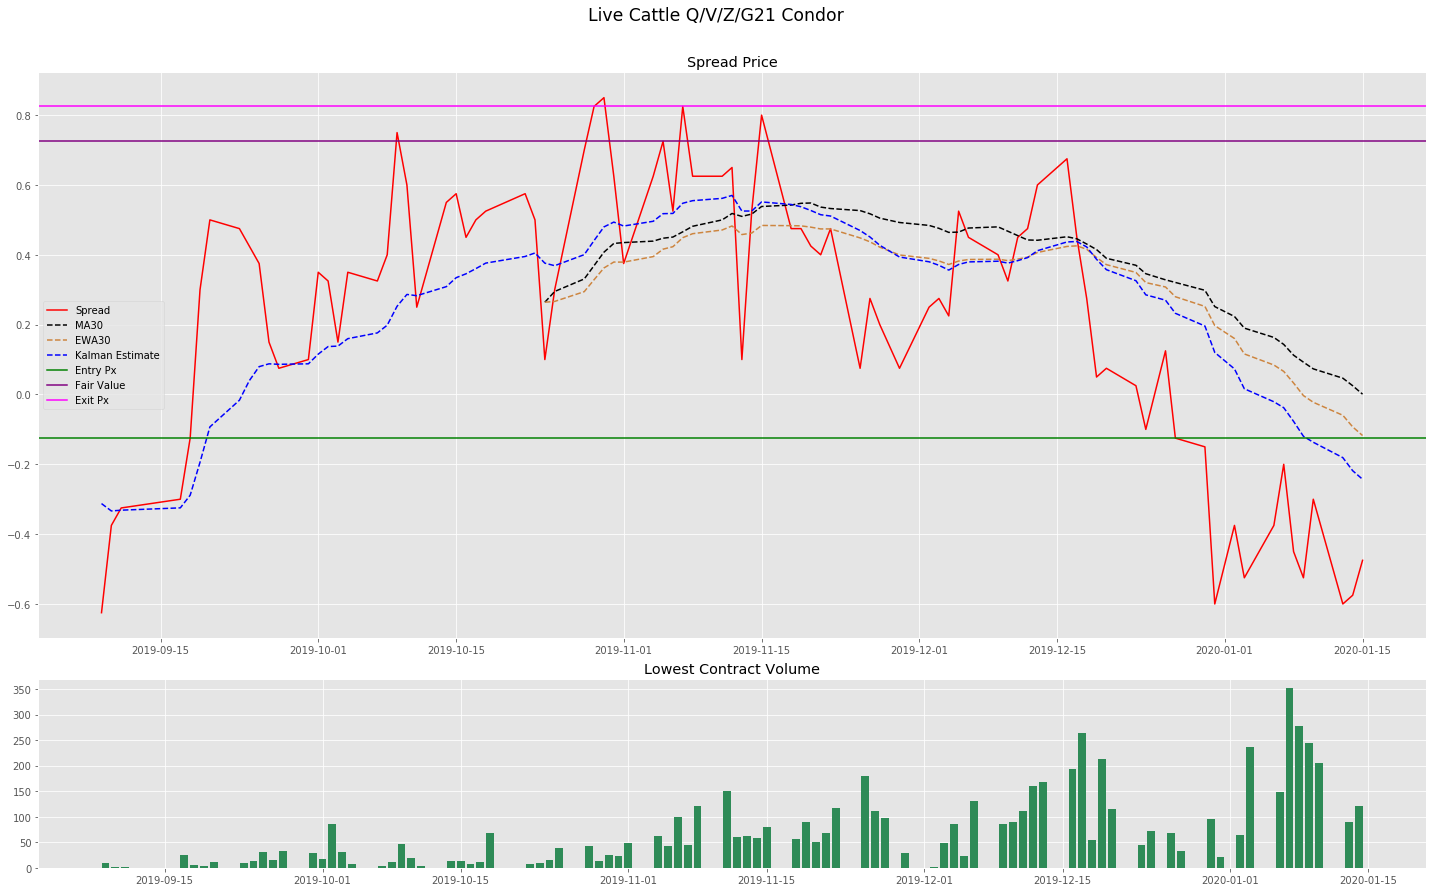

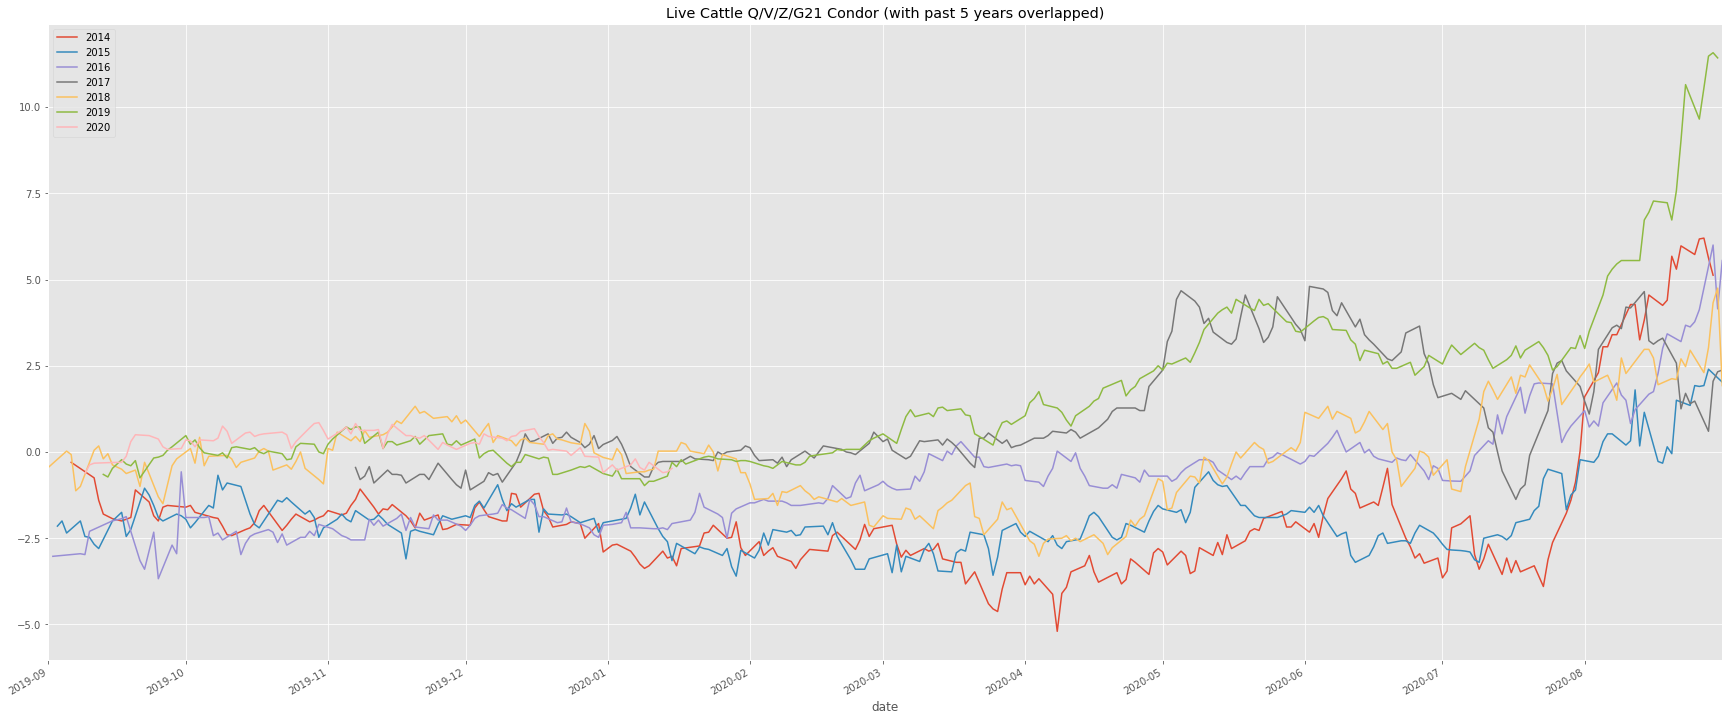

In [18]:
present_good_spread(8)

## #10 Gasoline RBOB M/N/Q/U20 Condor

'Backtest result of #10 Gasoline RBOB M/N/Q/U20 Condor'

Strategy  Win%  Lose%    WinΦ   LossΦ  Win_M  Loss_M  ProfitΦ  RRR    PF  \
400       HP  60.0   40.0  367.92 -224.28  363.3  -144.9   131.04  inf   2.5   
401      DHP  85.4   14.6  317.10 -124.32  235.2  -147.0   252.84  inf  15.0   
402       MA  62.2   37.8  237.30 -212.94  201.6  -197.4    66.78  1.7   1.8   
403        K  66.7   31.9  176.82 -180.60  168.0  -121.8    60.48  1.3   2.0   
404      EWA  62.2   37.8  184.80 -236.46  163.8  -235.2    25.62  1.4   1.3   
405   Kalman  60.0   40.0  152.46 -198.66  151.2  -220.5    12.18  1.0   1.2   
406     SISO  50.0   46.7  149.94 -177.24  144.9  -119.7    -7.98  0.6   0.9   
407     AIAO  54.9   42.4  156.24 -169.68  142.8  -130.2    13.86  1.0   1.2   

     Max_Drawdown    Best  Worst   A%  DaysΦ  Trades  
400        -844.2   646.8 -533.4  0.5   35.2    20.0  
401        -516.6  1054.2 -218.4  0.9   43.9    48.0  
402        -844.2   613.2 -533.4  0.7   30.4    37.0  
403        -638.4   445.2 -533.4  0.7   31.5    69.0  
404        -953.4   403.2 -533.4  0.5   30.1    37.0  
405        -428.4   357.0 -449.4  0.2   32.5    15.0  
406        -953.4   344.4 -680.4  0.4   19.1   180.0  
407        -953.4   520.8 -680.4  0.5   19.3   144.0

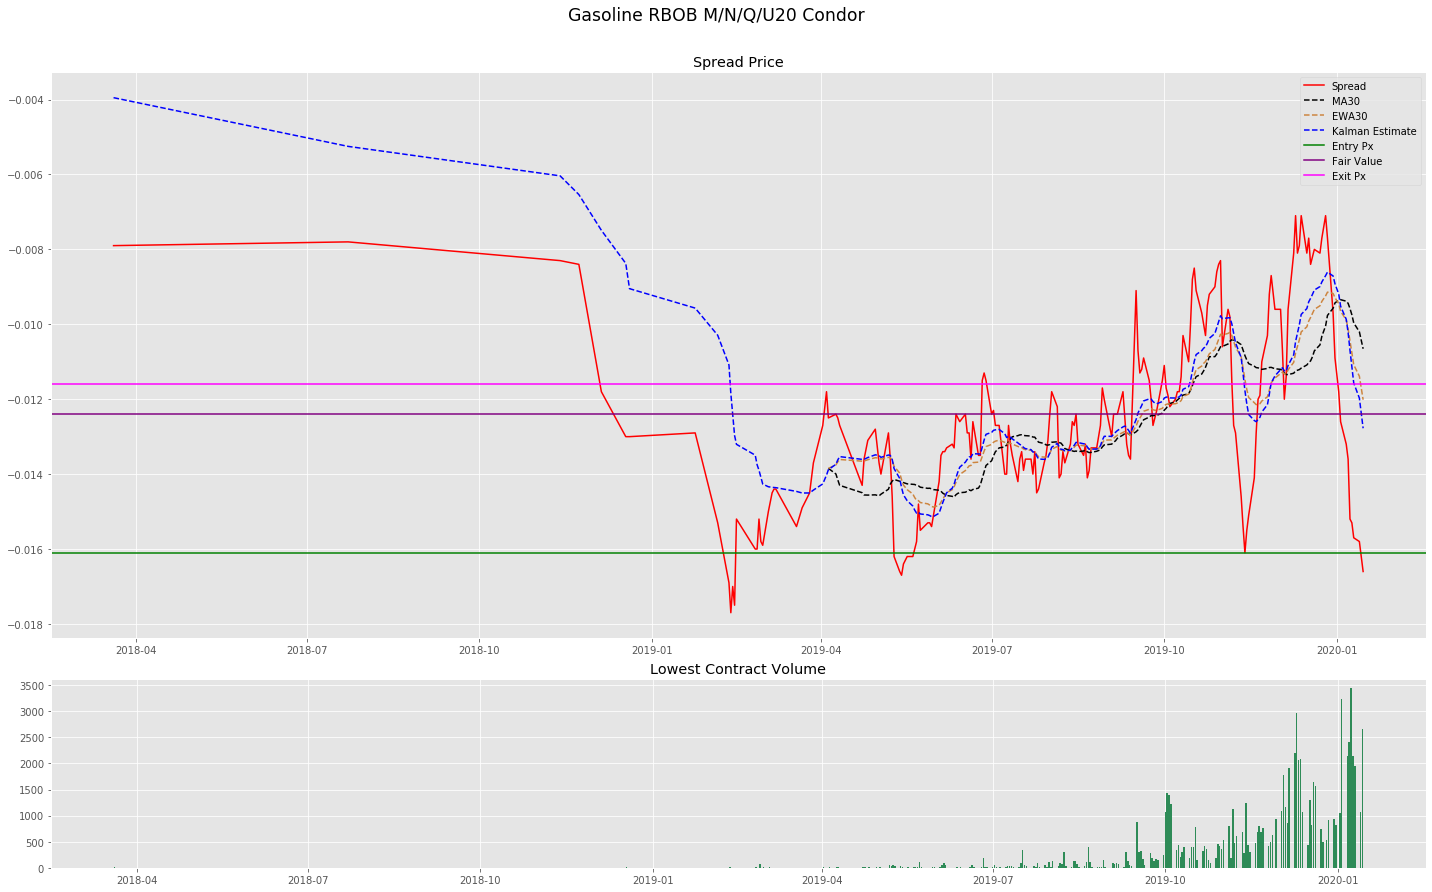

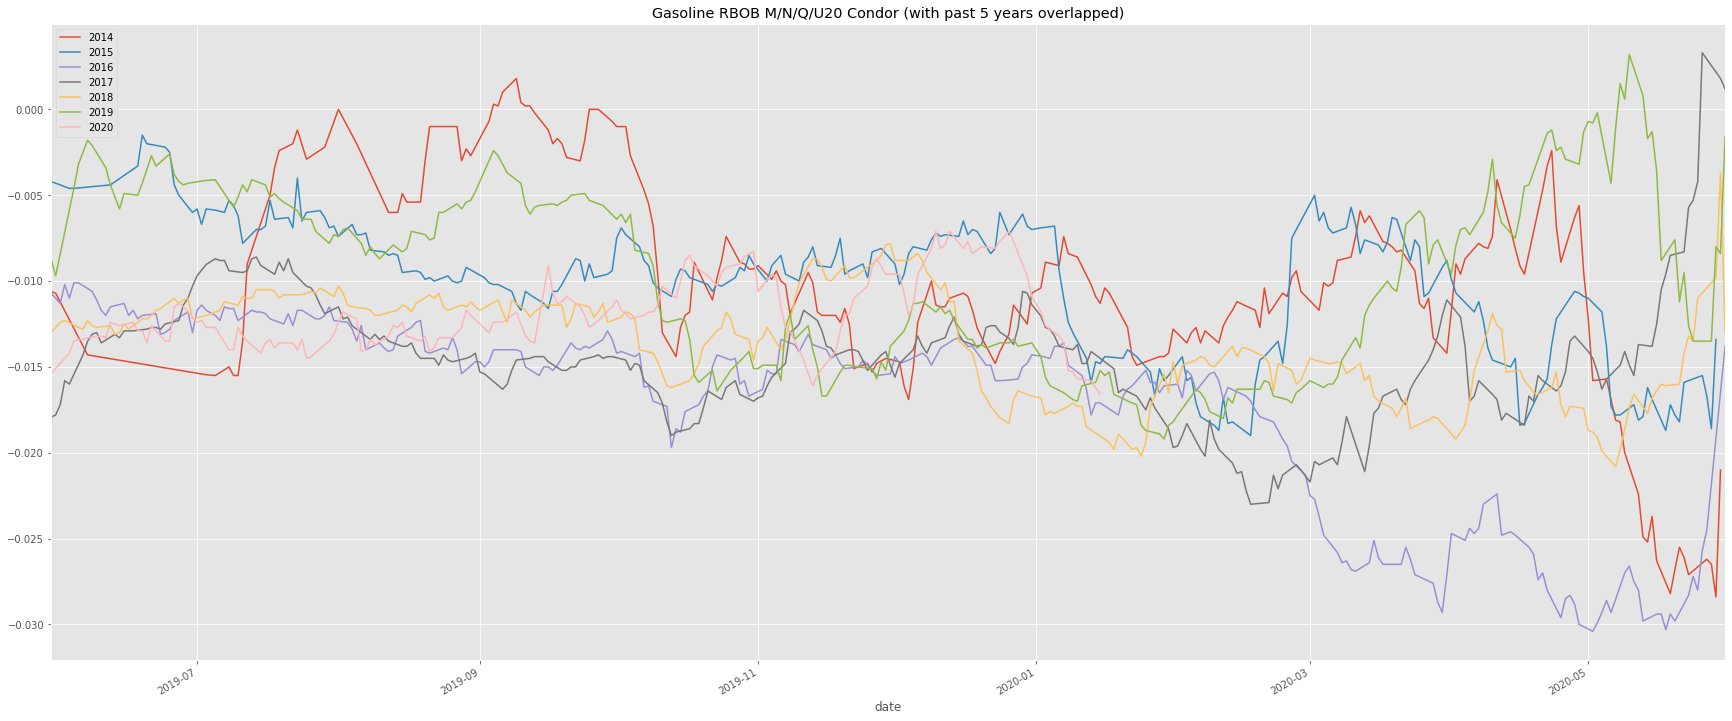

In [20]:
present_good_spread(9)